# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 05.10.2023

Мягкий дедлайн: 23:59MSK 18.10.2023

Жесткий дедлайн: 23:59MSK 22.10.2022

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [2]:
#!pip install folium

In [3]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'

# sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

np.random.seed(0)

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [3]:
# downloaded manually
df = pd.read_csv('train.csv')
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
df.isna().any()

id                    False
vendor_id             False
pickup_datetime       False
dropoff_datetime      False
passenger_count       False
pickup_longitude      False
pickup_latitude       False
dropoff_longitude     False
dropoff_latitude      False
store_and_fwd_flag    False
trip_duration         False
dtype: bool

*Пропусков не наблюдается*

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [5]:
df.shape

(1458644, 11)

In [6]:
df.drop(['dropoff_datetime'], inplace =True, axis=1)

In [7]:
df.shape[1]

10

In [8]:
df['pickup_datetime']  = pd.to_datetime(df['pickup_datetime'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   passenger_count     1458644 non-null  int64         
 4   pickup_longitude    1458644 non-null  float64       
 5   pickup_latitude     1458644 non-null  float64       
 6   dropoff_longitude   1458644 non-null  float64       
 7   dropoff_latitude    1458644 non-null  float64       
 8   store_and_fwd_flag  1458644 non-null  object        
 9   trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 111.3+ MB


*Все ок*

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

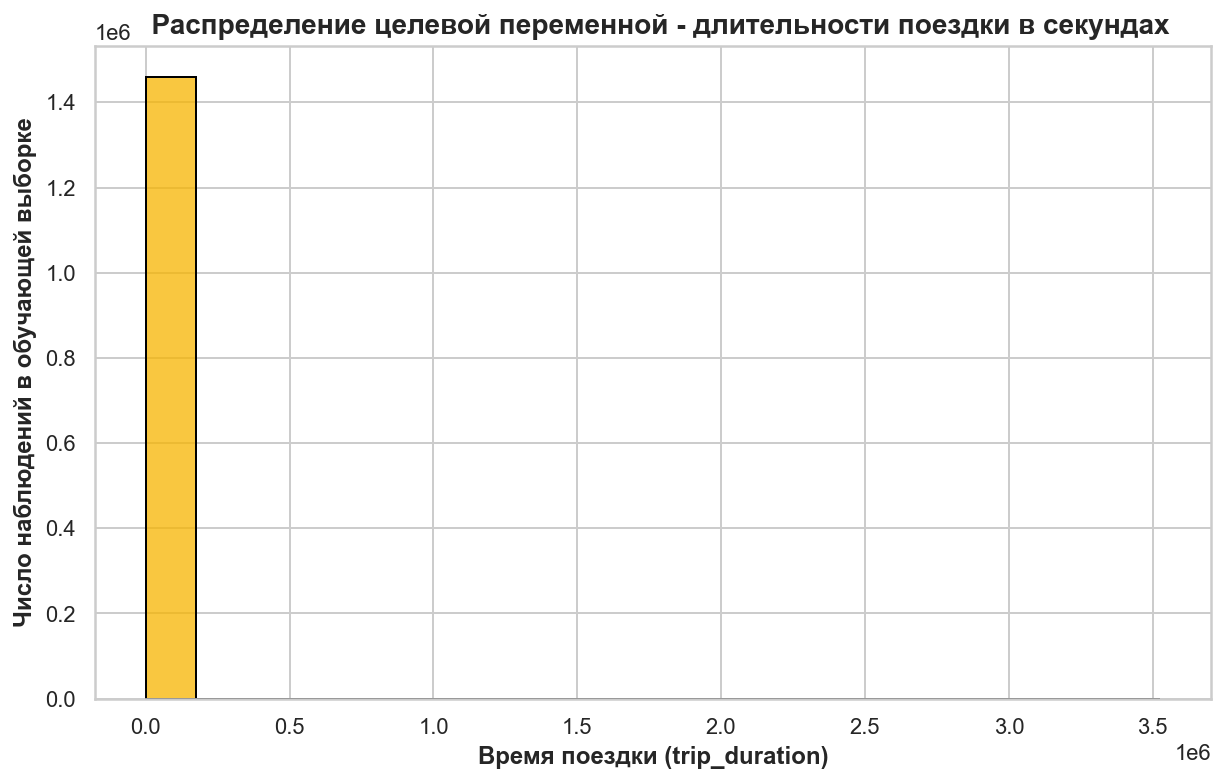

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('  Распределение целевой переменной - длительности поездки в секундах', fontsize=14,fontweight="bold")

plt.xlabel('Время поездки (trip_duration)',  fontsize=12, fontweight="bold")
plt.ylabel('Число наблюдений в обучающей выборке',  fontsize=12, fontweight="bold")
sns.histplot(data = df, x ='trip_duration',ax = ax, edgecolor = 'black', color = '#f8b500' , bins = 20);

Распределение целевой переменной далеко от нормального и очень сильно скошено влево. 

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

**Ответ:** Гистограмма показывает распределение целевой переменной. В частности - наличие выбросов, странных значений, которые потом нужно будет обработать.

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

 - Предсказание в секундах дает право сильно ошибаться, так как нас скорее будет интересовать время в минутах, ошибки в секундах будут не так страшны, если потом их переведем в минуты
 - Так как измеряем время в секундах - скорее нужно предсказать порядок времени. Так как в приложении например время выходит в минутах и дается примерно
 - Метрика больше штрафует за заниженный прогноз, то есть меньшее число времени. В случае работы  с такси нам как раз необходимо митигировать риски опоздания или значительной длительности поездки. *По личному опыту замечал, что такси нередко приезжает за меньшее время, чем указывалось в приложении* 

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: 
$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2} = \text{RMSE} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}=\sqrt{\text{MSE}\big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell}\big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}=\text{RMSLE}\big(\hat{y}_i,\hat{a}(x_i) \big)$

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [11]:
df['log_trip_duration'] = np.log1p(df['trip_duration'])

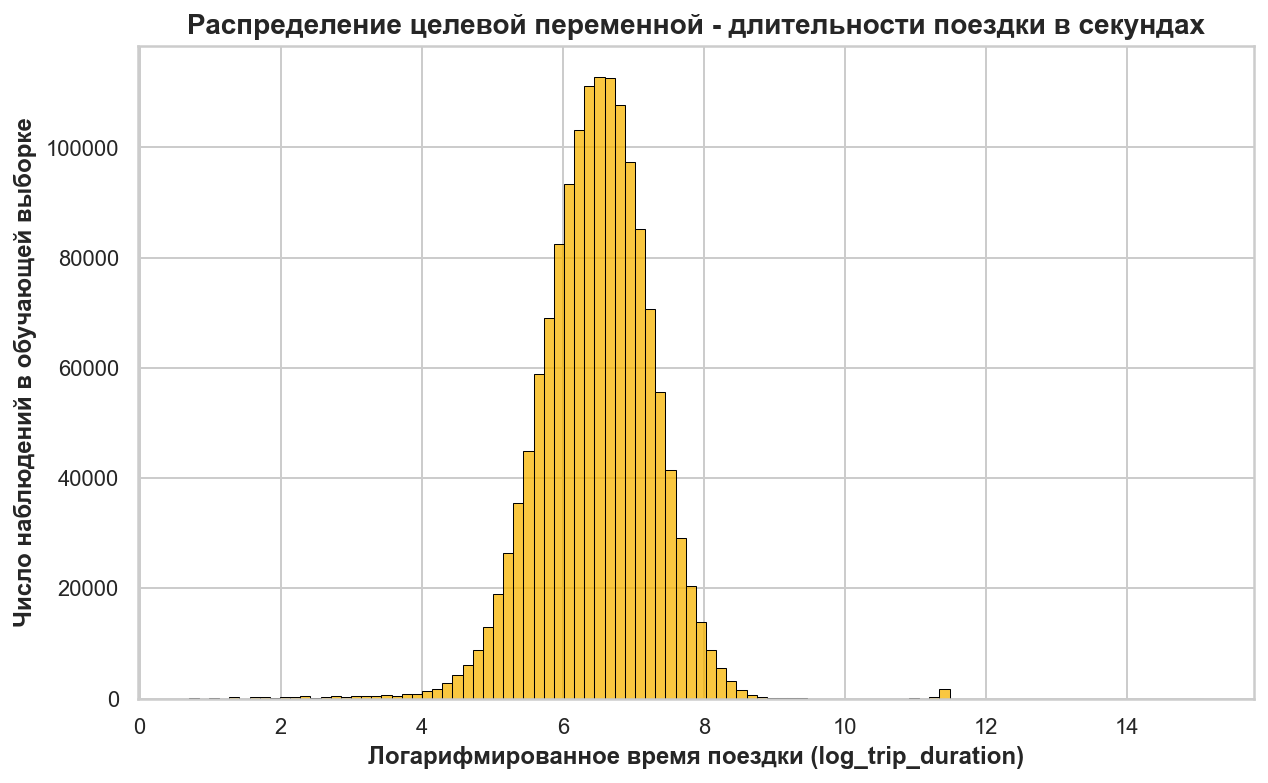

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Распределение целевой переменной - длительности поездки в секундах', fontsize=14, fontweight ='bold')

plt.xlabel('Логарифмированное время поездки (log_trip_duration)', fontsize=12,  fontweight ='bold')
plt.ylabel('Число наблюдений в обучающей выборке', fontsize=12, fontweight ='bold')
sns.histplot(data = df, x ='log_trip_duration',ax = ax, edgecolor = 'black',  color='#f8b500' , bins = 100);


Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [13]:
constant = np.repeat(np.mean(df['log_trip_duration']) , df.shape[0] )


rmsle_best_const =  mean_squared_error( constant,df['log_trip_duration'], squared=False) 
print(rmsle_best_const)
print("Если ошибка модели больше {}, то модель очень слабая ".format(round(rmsle_best_const, 4) ) )
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)


0.7957592365411504
Если ошибка модели больше 0.7958, то модель очень слабая 


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

In [14]:
trip_dates = pd.DataFrame(df['pickup_datetime'].dt.date.sort_values() )

In [15]:
trip_dates

,pickup_datetime
333752,2016-01-01
616306,2016-01-01
1391034,2016-01-01
1138825,2016-01-01
537651,2016-01-01
...,...
1061088,2016-06-30
1061098,2016-06-30
1253084,2016-06-30
1268014,2016-06-30


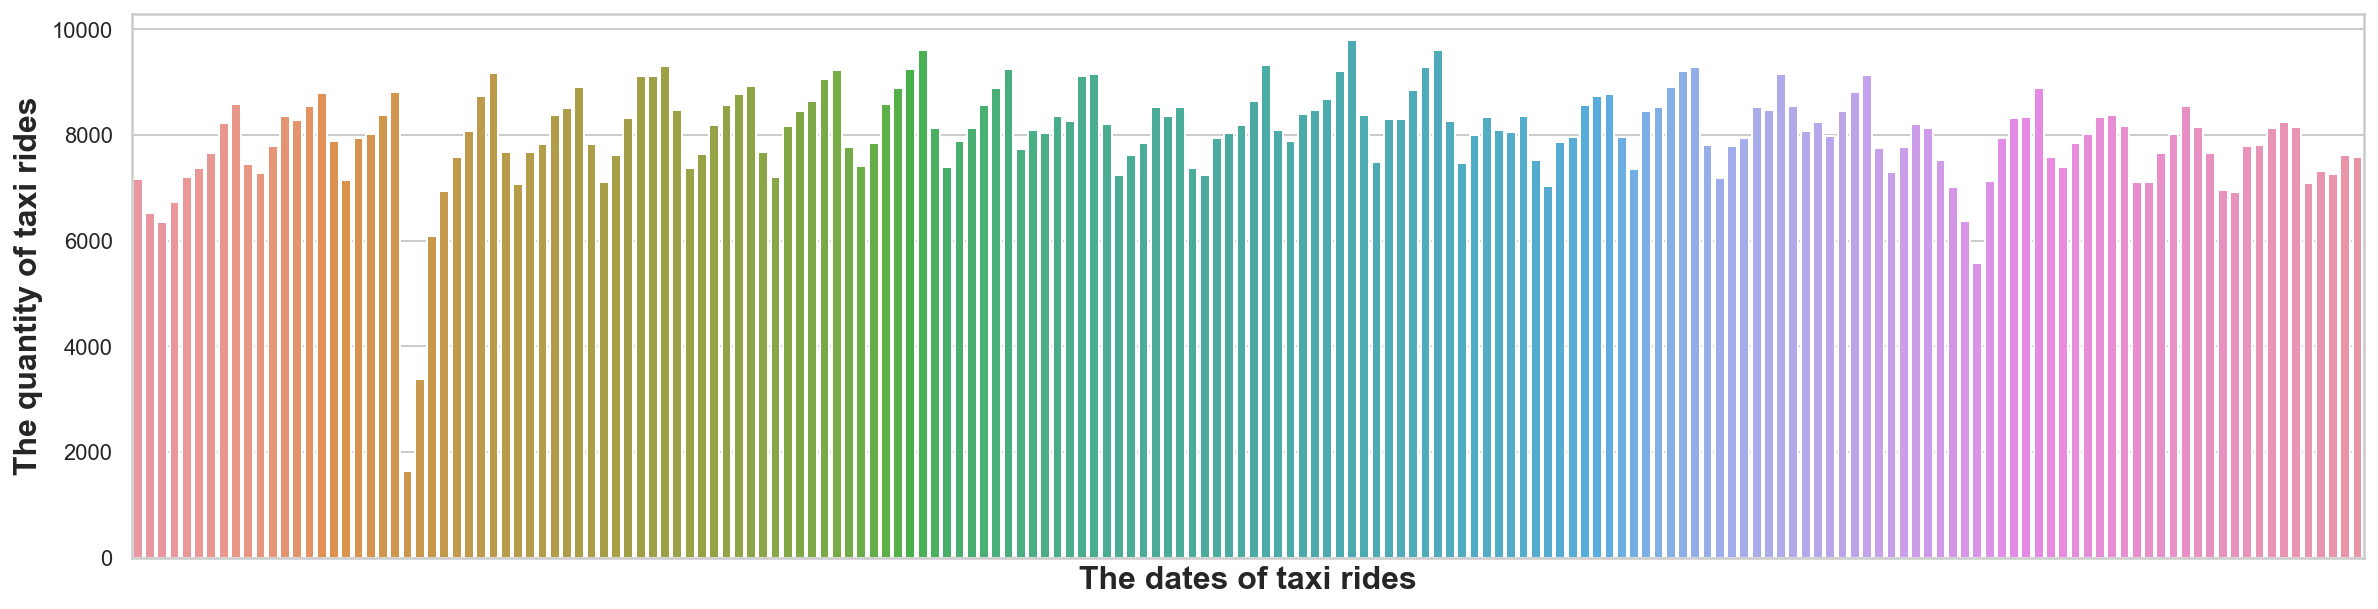

In [16]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title('', fontsize=18, fontweight ='bold')

sns.countplot(data = trip_dates, x ='pickup_datetime',ax = ax );

plt.xlabel('The dates of taxi rides', fontsize=16, fontweight ='bold')
plt.ylabel('The quantity of taxi rides', fontsize=16, fontweight ='bold')
plt.xticks([]);
#Иначе полный mess для xticks 

Помимо наличия аномально низких значений,также можно заметить определенную цикличность в течении недели -  как будто ближе к выходным число поездок сильно выростает.

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [17]:
trip_dates['pickup_datetime'].value_counts().sort_values().head()

2016-01-23    1648
2016-01-24    3383
2016-05-30    5570
2016-01-25    6084
2016-01-03    6353
Name: pickup_datetime, dtype: int64

**Ответ** :
 -  [2016.01.23 - 2016.01.25](https://www.usatoday.com/story/weather/2016/01/23/blizzard-continues-slam-east-coast/79217258/) Снежная буря и запрет на поездки 
 -  [2016.05.29 - 2016.05.30](https://www.govinfo.gov/features/memorial-day-2016#:~:text=Memorial%20Day%2C%20Monday%2C%20May%2030,the%20last%20Monday%20in%20May.) День Памяти (Memorial day) - пришелся как раз на конец мая 2016 года

In [18]:
trips_stat = df.groupby('pickup_datetime', as_index = False)['id'].count()
trips_stat['date'] = pd.to_datetime(trips_stat['pickup_datetime'] )  
trips_stat['day'] = trips_stat['date'].dt.day_of_week   


days  = trips_stat.groupby('day', as_index =False)['id'].count()
days

,day,id
0,0,178074
1,1,191939
2,2,198641
3,3,206183
4,4,211074
5,5,208628
6,6,185683


*График зависимости количества поездок от дня недели*

<Figure size 720x432 with 0 Axes>

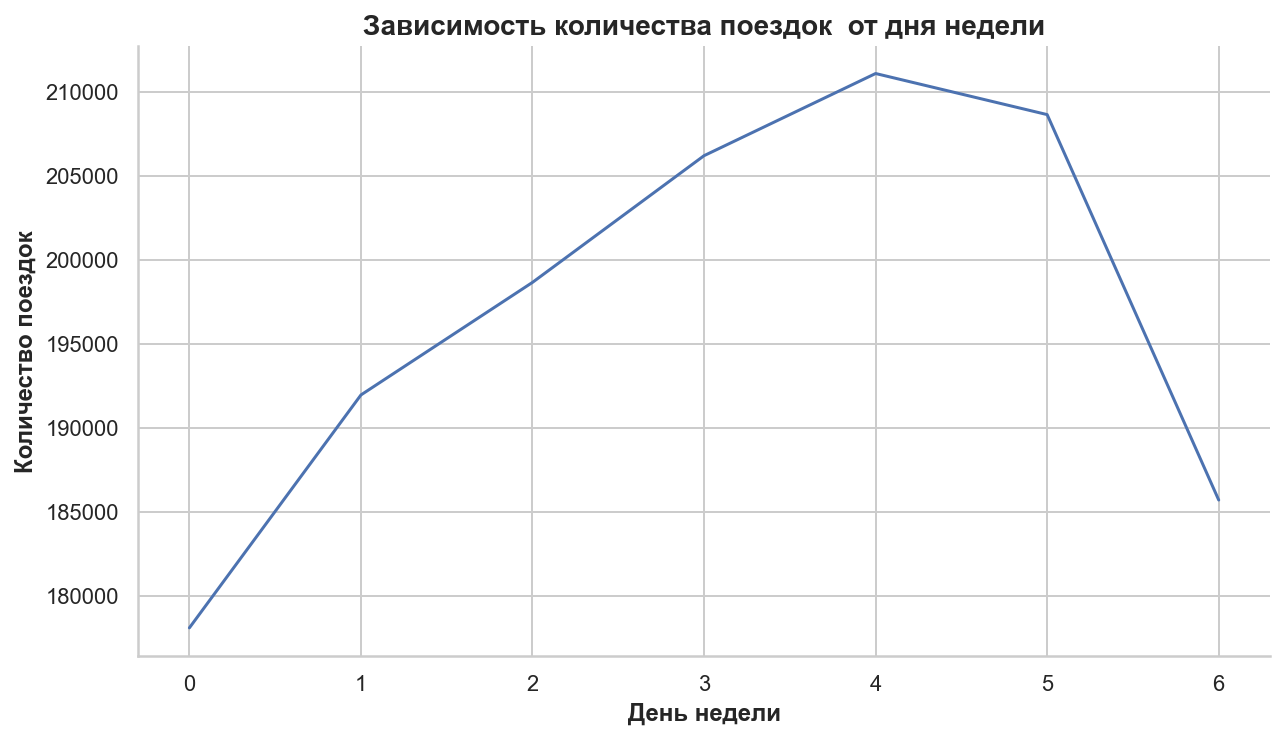

In [19]:
plt.figure(figsize=(10,6))
sns.relplot(data = days, y ='id', x ='day', kind= 'line', height=5,  aspect=1.8);
plt.title('Зависимость количества поездок  от дня недели', fontsize=14, fontweight ='bold')
plt.xlabel('День недели', fontsize=12,  fontweight ='bold')
plt.ylabel('Количество поездок', fontsize=12, fontweight ='bold')
#plt.xticks(np.arange(7), labels=['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье'] )
plt.show();

Кооличество поездовк уверенно растет по дням, достигая своего пика в ... *Пятницу...*  Что-то мне подсказывает, что дальше мы узнаем еще и про *вечер пятницы*. 

In [21]:
trips_stat['hour'] = trips_stat['pickup_datetime'].dt.hour
hours_trips = trips_stat.groupby([ 'hour'], as_index =False)['id'].count()
hours_trips.head()

,hour,id
0,0,50663
1,1,36970
2,2,26994
3,3,20351
4,4,15523


<Figure size 720x432 with 0 Axes>

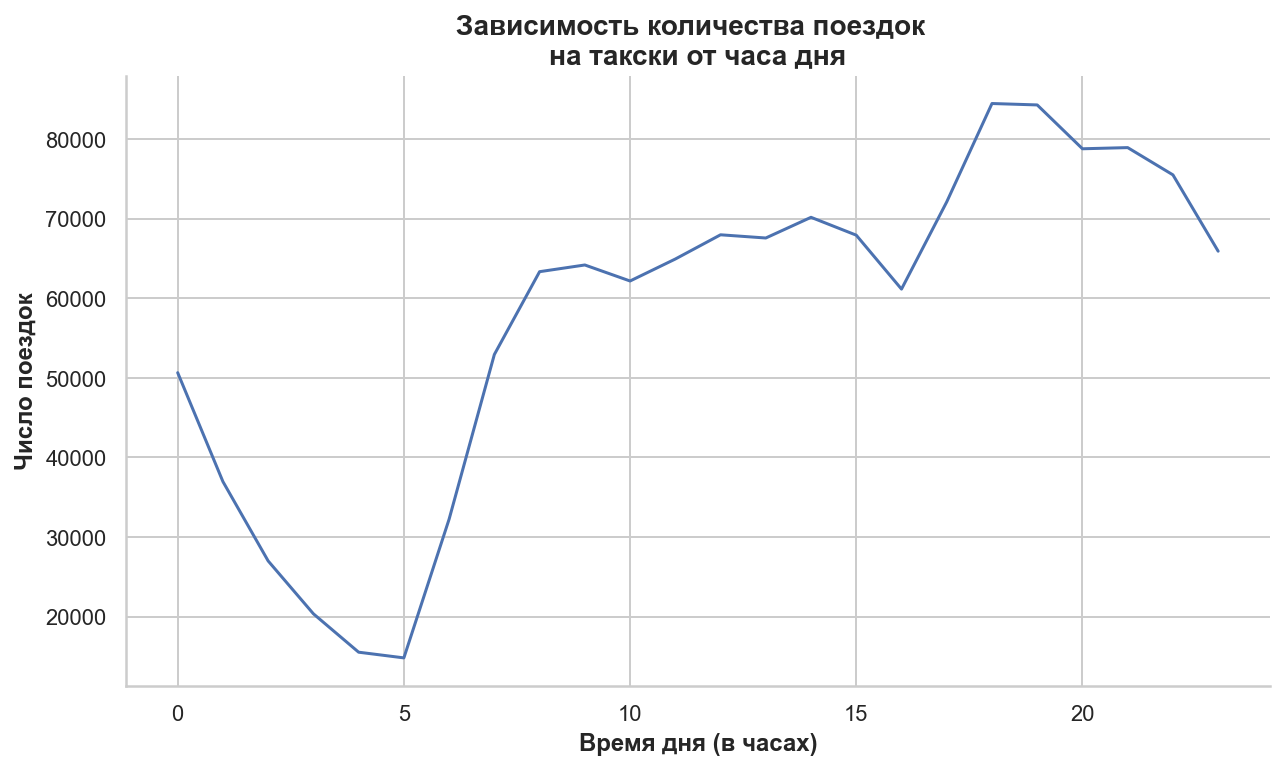

In [22]:
plt.figure(figsize=(10,6))
sns.relplot(data = hours_trips, y ='id', x ='hour', kind= 'line', height=5,  aspect=1.8)
plt.title('Зависимость количества поездок  \nна такски от часа дня', fontsize=14, fontweight ='bold')
plt.xlabel('Время дня (в часах)', fontsize=12,  fontweight ='bold')
plt.ylabel('Число поездок', fontsize=12, fontweight ='bold')
plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

Гитотеза о *вечере*  оправдалась, но сам пик приходиться на 19.00 примерно, я ожидал более поздний период. 

In [23]:
trips_stat

,pickup_datetime,id,date,day,hour
0,2016-01-01 00:00:17,1,2016-01-01 00:00:17,4,0
1,2016-01-01 00:00:53,1,2016-01-01 00:00:53,4,0
2,2016-01-01 00:01:01,1,2016-01-01 00:01:01,4,0
3,2016-01-01 00:01:14,1,2016-01-01 00:01:14,4,0
4,2016-01-01 00:01:20,1,2016-01-01 00:01:20,4,0
...,...,...,...,...,...
1380217,2016-06-30 23:58:52,1,2016-06-30 23:58:52,3,23
1380218,2016-06-30 23:59:09,1,2016-06-30 23:59:09,3,23
1380219,2016-06-30 23:59:10,1,2016-06-30 23:59:10,3,23
1380220,2016-06-30 23:59:37,1,2016-06-30 23:59:37,3,23


In [24]:
trips_stat['month'] = trips_stat['pickup_datetime'].dt.month
month_hour = trips_stat.groupby(['month', 'hour'], as_index  = False)['id'].count()
month_hour.head()

,month,hour,id
0,1,0,7942
1,1,1,6108
2,1,2,4664
3,1,3,3466
4,1,4,2558


In [25]:
palette_months =['#e6194b', '#3cb44b', '#e6194B', '#4363d8', '#f58231', '#911eb4']
palette_days =['#e6194b', '#3cb44b', '#e6194B', '#4363d8', '#f58231', '#911eb4', '#f032e6']

*Источник вдохновения контрастности - [ссылка](https://sashamaps.net/docs/resources/20-colors/)*

<Figure size 720x432 with 0 Axes>

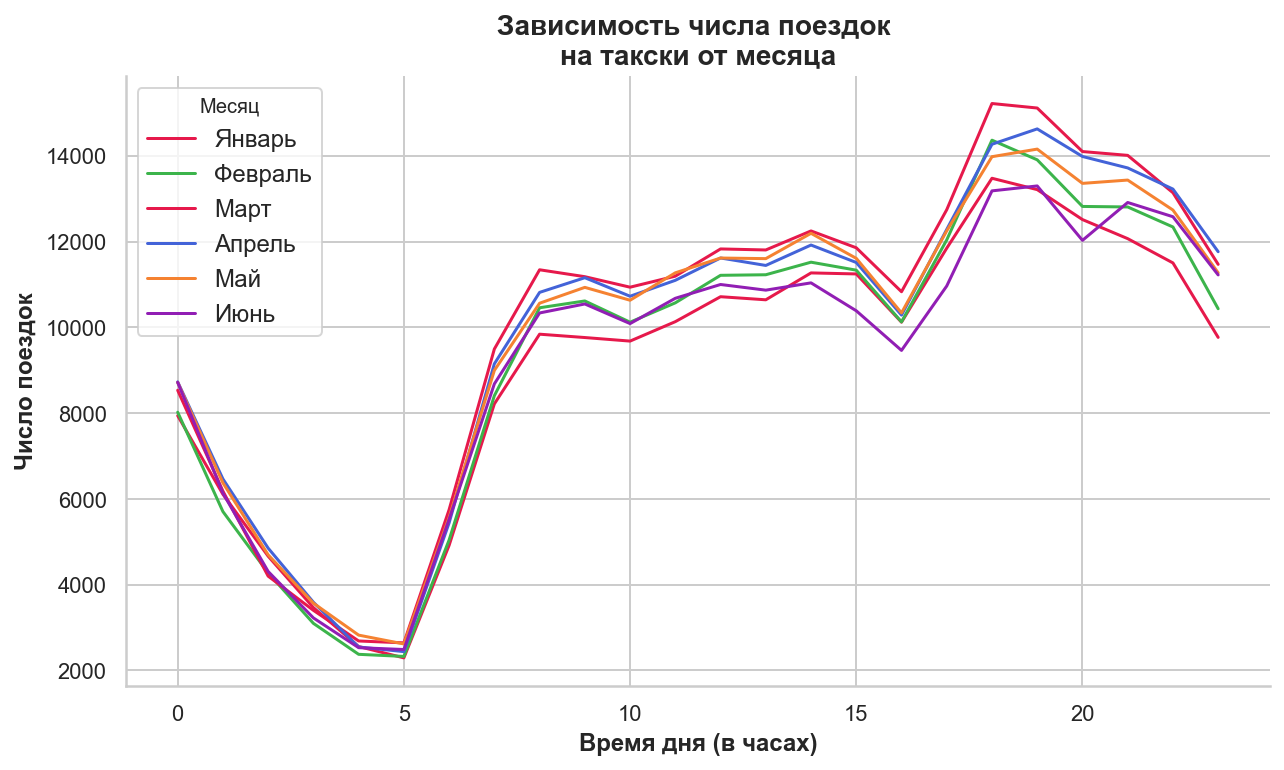

In [26]:
plt.figure(figsize=(10,6))
sns.relplot(data = month_hour, y ='id', x ='hour', kind= 'line',hue = 'month', height=5,  aspect=1.8, legend = False,
            palette = palette_months)
plt.title('Зависимость числа поездок \nна такски от месяца', fontsize=14, fontweight ='bold')
plt.xlabel('Время дня (в часах)', fontsize=12,  fontweight ='bold')
plt.ylabel('Число поездок', fontsize=12, fontweight ='bold')
plt.legend(title='Месяц', labels=['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь'], title_fontsize=10, fontsize=12
         )
plt.show();

In [27]:
day_hour = trips_stat.groupby(['day', 'hour'], as_index  = False)['id'].count()
day_hour.head()

,day,hour,id
0,0,0,4173
1,0,1,2536
2,0,2,1642
3,0,3,1218
4,0,4,1344


<Figure size 720x432 with 0 Axes>

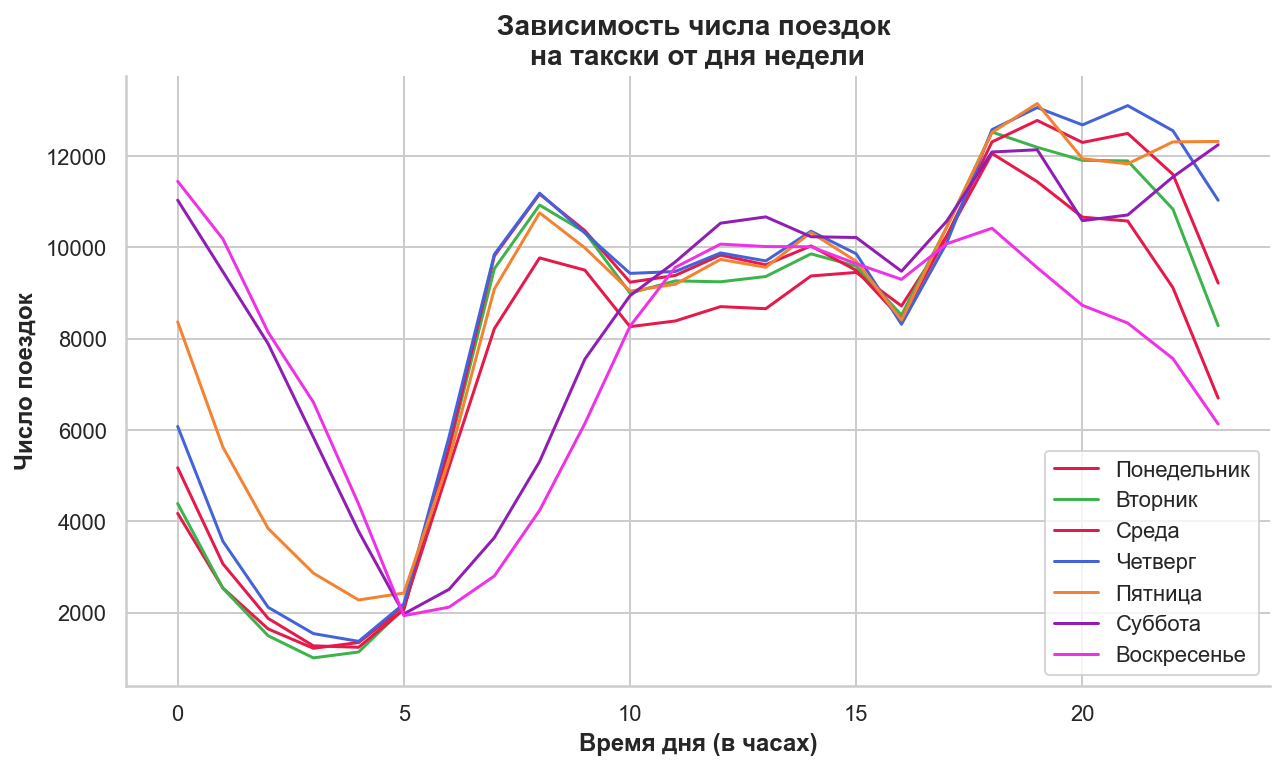

In [28]:
plt.figure(figsize=(10,6))
sns.relplot(data = day_hour, y ='id', x ='hour', kind= 'line',hue = 'day', height=5,  aspect=1.8, legend = False,
           palette = palette_days)
plt.title('Зависимость числа поездок \nна такски от дня недели', fontsize=14, fontweight ='bold')
plt.xlabel('Время дня (в часах)', fontsize=12,  fontweight ='bold')
plt.ylabel('Число поездок', fontsize=12, fontweight ='bold')
plt.legend( labels=['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье'], loc = 'best' )
plt.show();

Интересно как сильно воскресение отличается от остальных дней  - сильный сдвиг подьема от примерно 7 часов к 12. Похоже все спят. Сам подьем плавнее, чем для других дней недели, так как в воскресение нет какого-нибудь важного события, чтоб все Нью-Йоркцы разом на него ринулись еще и на такси.

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Ответ: **
 - *Дни* - число поездок с понедельника (минимальное число поездок) растет до пятницы, это пик, далее падает. Хоть и для субботы значение все еще выше для всех будней, кроме пятницы. 
 - *Месяцы* - хоть и месяца накладываются друг на друга, можно заметить что март вырывается вперед - возможно пик деловой активности. А июнь и январь скорее внизу - люди скорее в отъезде. 
 - *Время суток* - с 5 до 8 утра идет сильный рост, с 8 до 15 часов роста почти нет. После проседания примернов 16 часов, с 17 до 20 часов сильный рост и пик в 19 часов, далее число поездок идет на спад. 
 



**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [29]:
X_train, X_test = train_test_split(df, train_size=0.7, test_size=0.3, random_state=42)

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [30]:
anomalous_dates = [23, 25, 25, 150]
df['month'] = df['pickup_datetime'].dt.month
df['hour'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.day_of_week   
df['day_of_year'] = df['pickup_datetime'].dt.day_of_year
df['anomalous_date'] = np.where(df['day_of_year'].isin(anomalous_dates), 1, 0)
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,month,hour,day_of_week,day_of_year,anomalous_date
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493,3,17,0,74,0
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282,6,0,6,164,0
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527,1,11,1,19,0
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785,4,19,2,97,0
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642,3,13,5,86,0


*День недели*

<Figure size 720x432 with 0 Axes>

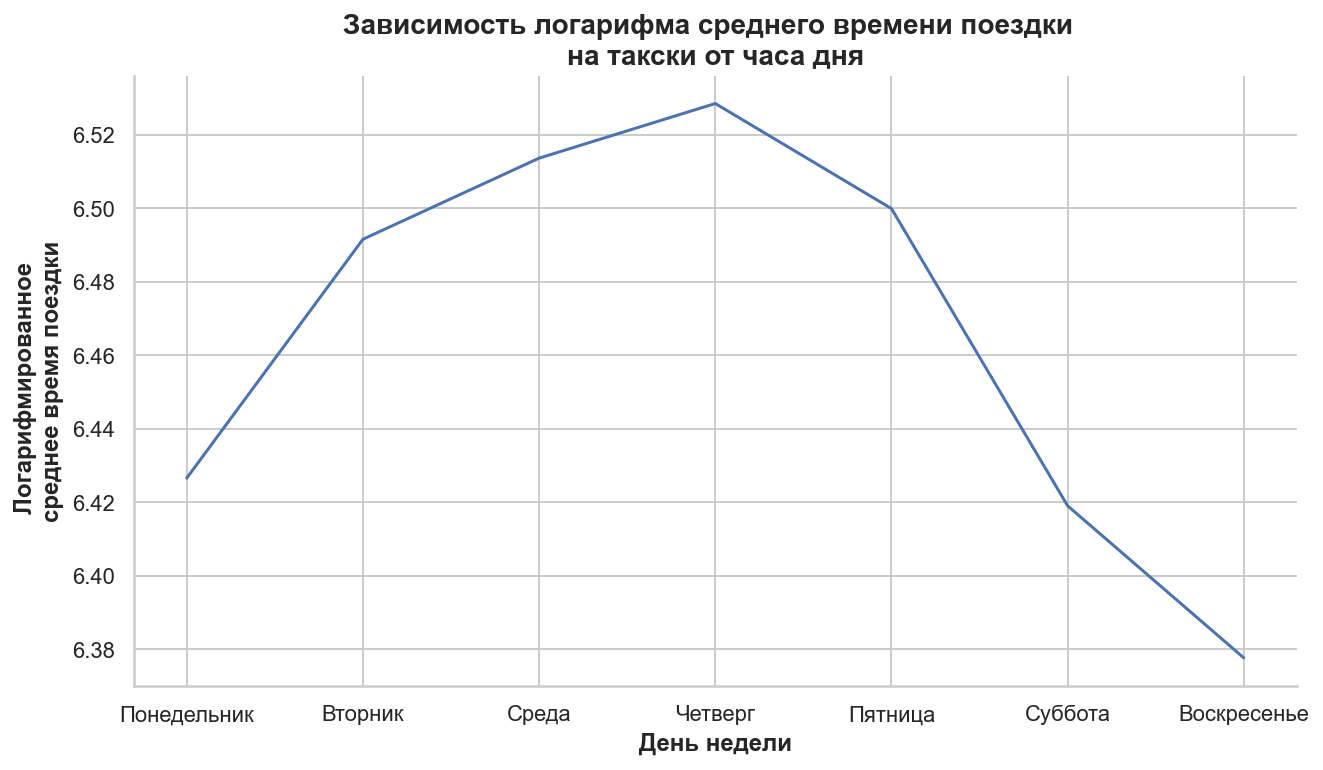

In [31]:
days = df.groupby('day_of_week', as_index =False)['log_trip_duration'].mean()
plt.figure(figsize=(10,6))
sns.relplot(data = days, y ='log_trip_duration', x ='day_of_week', kind= 'line', height=5,  aspect=1.8)
plt.title('Зависимость логарифма среднего времени поездки  \nна такски от часа дня', fontsize=14, fontweight ='bold')
plt.xlabel('День недели', fontsize=12,  fontweight ='bold')
plt.ylabel('Логарифмированное  \nсреднее время поездки', fontsize=12, fontweight ='bold')
plt.xticks(np.arange(7), labels=['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье'] )
plt.show();

*Время дня*

<Figure size 720x432 with 0 Axes>

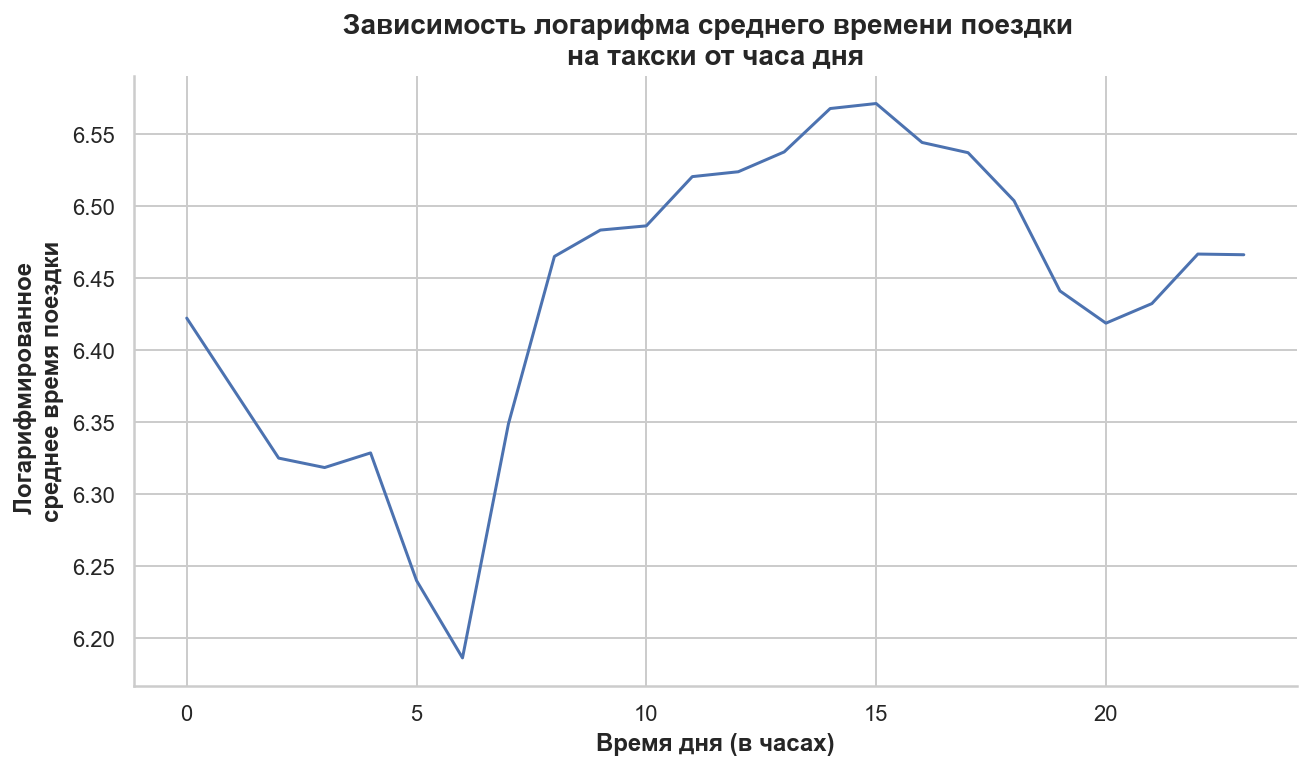

In [32]:
day_time = df.groupby('hour', as_index = False)['log_trip_duration'].mean()
plt.figure(figsize=(10,6))
sns.relplot(data = day_time, y ='log_trip_duration', x ='hour', kind= 'line', height=5,  aspect=1.8)
plt.title('Зависимость логарифма среднего времени поездки  \nна такски от часа дня', fontsize=14, fontweight ='bold')
plt.xlabel('Время дня (в часах)', fontsize=12,  fontweight ='bold')
plt.ylabel('Логарифмированное  \nсреднее время поездки', fontsize=12, fontweight ='bold')
plt.show()

*Месяц*

<Figure size 720x432 with 0 Axes>

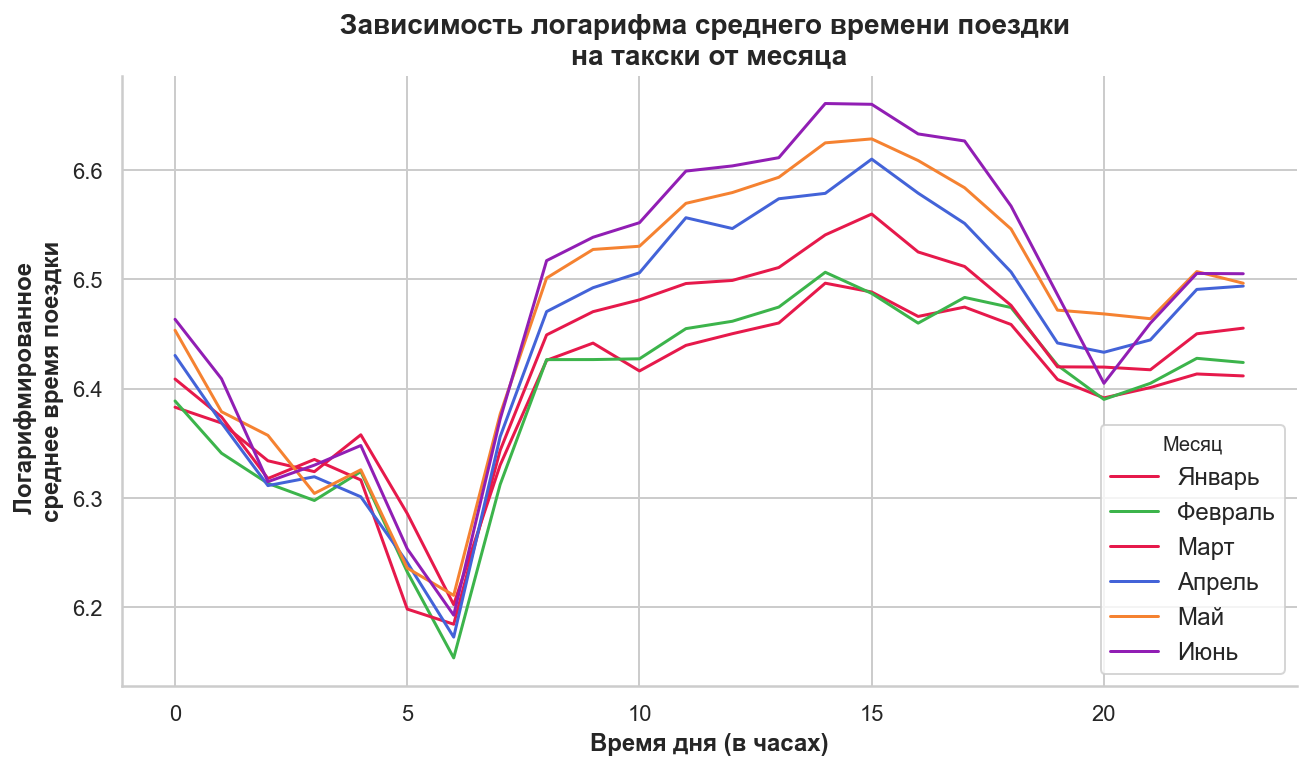

In [33]:
hour_month = df.groupby(['month', 'hour'], as_index= False)['log_trip_duration'].mean()

plt.figure(figsize=(10,6))
sns.relplot(data = hour_month , y ='log_trip_duration', x ='hour', kind= 'line',hue = 'month', height=5,  aspect=1.8, legend = False,
            palette = palette_months)
plt.title('Зависимость логарифма среднего времени поездки \nна такски от месяца', fontsize=14, fontweight ='bold')
plt.xlabel('Время дня (в часах)', fontsize=12,  fontweight ='bold')
plt.ylabel('Логарифмированное  \nсреднее время поездки', fontsize=12, fontweight ='bold')
plt.legend(title='Месяц', labels=['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь'], title_fontsize=10, fontsize=12
)
plt.show();

*День недели*

<Figure size 720x432 with 0 Axes>

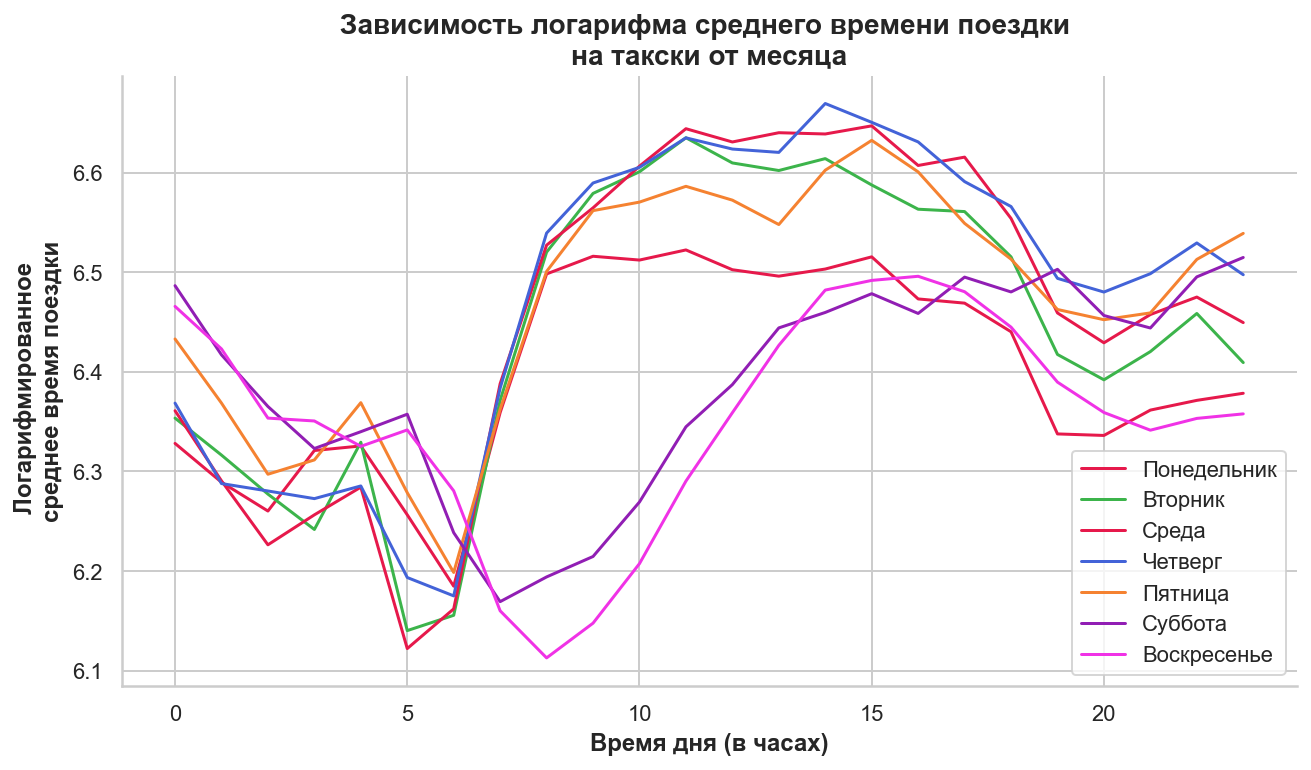

In [34]:
day_hour = df.groupby([ 'day_of_week', 'hour'], as_index= False)['log_trip_duration'].mean()
plt.figure(figsize=(10,6))
sns.relplot(data = day_hour, y ='log_trip_duration', x ='hour', kind= 'line',hue = 'day_of_week', height=5,  aspect=1.8, legend = False,
            palette = palette_days)
plt.title('Зависимость логарифма среднего времени поездки \nна такски от месяца', fontsize=14, fontweight ='bold')
plt.xlabel('Время дня (в часах)', fontsize=12,  fontweight ='bold')
plt.ylabel('Логарифмированное  \nсреднее время поездки', fontsize=12, fontweight ='bold')
plt.legend( labels=['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье'], loc = 'best' )
plt.show();


Отличия : 
 - *День* - наибольшее среднее логарифмированное время приходится  на четверг. Возможно командировки в пределах города или поездка загород
 - *Час дня* - самые короткие поездки в 5 утра. Пик - в 15.00, что логично так как длинные поездки скорее будут происходить ближе в середине дня,а не рано утром и ночью по соображениям цены
 - *Месяц* - наиболее долгие поездки в среднем наблюдается в июне, наиболее быстрые в марте и феврале. Предполагаю погодные условия, усиление туризма ближе к лету.
 - *День недели* - от будней к выходным идет сильное уменьшение времени поездки. Возможно люди чаще сидят дома


Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

*Ответ:* 
 -  так как увидели изменение числа поездок и также длительность в зависимости от месяца и дня, то ```day_of_year``` численный
 - ```day_of_week```, ```month```, ```hour```, ```anomalous_date``` - категориальные, так как их можно лишь сравнить, но не вычесть или сложить

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [35]:
X_train, X_test = train_test_split(df, train_size=0.7, test_size=0.3, random_state=42)

y_train = X_train['log_trip_duration']
y_test = X_test['log_trip_duration']

X_train = X_train.drop('log_trip_duration', axis=1)
X_test = X_test.drop('log_trip_duration', axis=1)

In [36]:
X_time_train = X_train[['anomalous_date', 'day_of_week', 'month', 'hour', 'day_of_year']]
X_time_test = X_test[['anomalous_date', 'day_of_week', 'month', 'hour', 'day_of_year']]

In [37]:
encoder = OneHotEncoder(sparse=False)

X_time_train_categorical = encoder.fit_transform(X_time_train[['anomalous_date', 'day_of_week', 'month', 'hour']])
X_time_test_categorical = encoder.transform(X_time_test[['anomalous_date', 'day_of_week', 'month', 'hour']])

scaler = StandardScaler()

X_time_train_numerical = scaler.fit_transform(X_time_train[['day_of_year']])
X_time_test_numerical= scaler.transform(X_time_test[['day_of_year']])

In [53]:
X_time_train_all

array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.62391343],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -1.76116223],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.4493957 ],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -1.27639075],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -1.41212676],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         0.        , -0.98552787]])

In [38]:
X_time_train_all = np.concatenate((X_time_train_categorical,X_time_train_numerical), axis=1)
X_time_test_all = np.concatenate((X_time_test_categorical,X_time_test_numerical), axis=1)

In [39]:
model = Ridge(random_state=42)

model.fit(X_time_train_all, y_train)
pred_test = model.predict(X_time_test_all)
pred_train = model.predict(X_time_train_all)


In [40]:
test_rmse = mean_squared_error(pred_test, y_test, squared=False)
train_rmse = mean_squared_error(pred_train, y_train, squared=False)

In [41]:
print(f'RMSLE на тесте: {round(test_rmse, 5)}, \nRMSLE на трейне: {round(train_rmse, 5)}')

RMSLE на тесте: 0.7882, 
RMSLE на трейне: 0.78911


Ошибка по среднему, самому примитивному предсказанию была - 0.7958. Так что первая модель уже строит все не так плохо.

## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [42]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [43]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [44]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

**Ответ:** Большинство точек сконцентрировано в районе Манхэттена. Если смотреть правее - концентрация около международного аэропорта JFK. И точки отчати рассеяны между аэропортом и Манхэттеном в районе Бруклина.

$t = \frac{s}{v}$

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [45]:
# легитимно реквезируем с 1 семинара
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [46]:
df.loc[:, 'haversine'] = haversine_array(df['pickup_latitude'].values, df['pickup_longitude'].values,
                                         df['dropoff_latitude'].values, df['dropoff_longitude'].values)
X_train.loc[:, 'haversine'] = haversine_array(X_train['pickup_latitude'].values, X_train['pickup_longitude'].values,
                                              X_train['dropoff_latitude'].values, X_train['dropoff_longitude'].values)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [47]:
df['log_haversine'] = np.log1p(df['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [48]:
your_df = df
assert your_df['log_haversine'].corr(your_df['log_trip_duration']) > your_df['haversine'].corr(your_df['log_trip_duration'])

In [49]:
check_correlation = df[['log_haversine', 'haversine', 'log_trip_duration']]

<AxesSubplot:xlabel='Длительность поездки', ylabel='Логарифмированное время поездки \n(log_trip_duration)'>

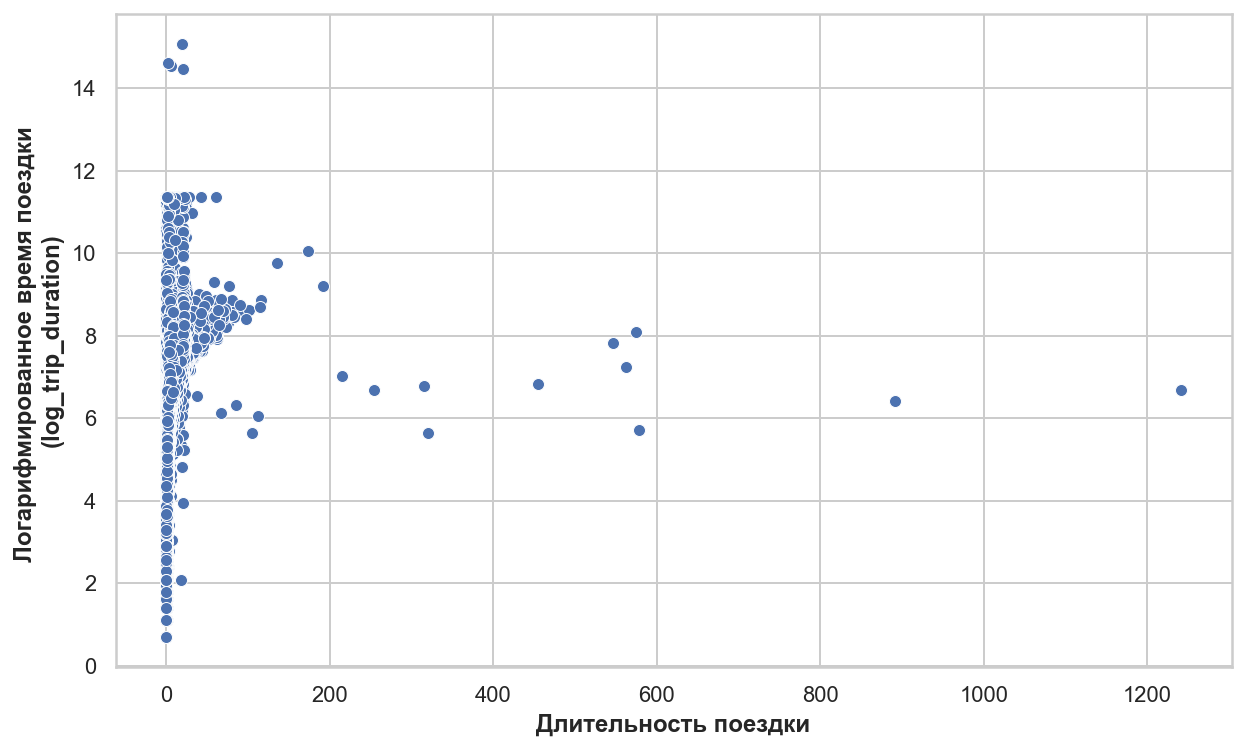

In [50]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.xlabel('Длительность поездки', fontsize=12,  fontweight ='bold')
plt.ylabel('Логарифмированное время поездки \n(log_trip_duration)', fontsize=12, fontweight ='bold')
sns.scatterplot(data =check_correlation, x ='haversine', y='log_trip_duration',ax = ax)

<AxesSubplot:xlabel='Логарифм длительность поездки', ylabel='Логарифмированное время поездки \n(log_trip_duration)'>

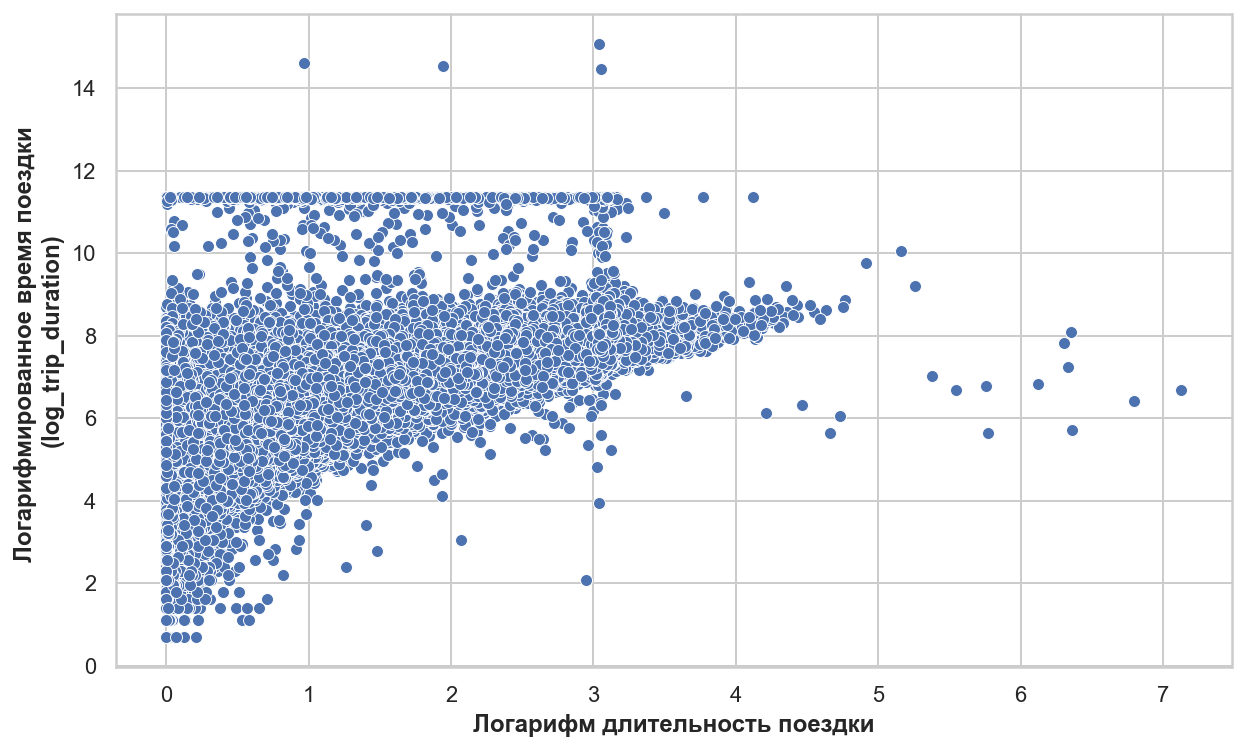

In [51]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.xlabel('Логарифм длительность поездки', fontsize=12,  fontweight ='bold')
plt.ylabel('Логарифмированное время поездки \n(log_trip_duration)', fontsize=12, fontweight ='bold')
sns.scatterplot(data =check_correlation, x ='log_haversine', y='log_trip_duration',ax = ax)

Так точно выглядит лучше!

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [52]:
X_train

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,hour,day_of_week,day_of_year,anomalous_date,haversine
1011257,id2209155,2,2016-05-03 09:03:08,2,-73.979813,40.752529,-73.982681,40.763680,N,844,5,9,1,124,0,1.263187
178550,id0586605,1,2016-01-01 16:40:51,1,-73.977623,40.746296,-73.968414,40.788933,N,1001,1,16,4,1,0,4.804012
551460,id0467144,1,2016-04-24 13:57:03,1,-73.950699,40.779404,-73.863129,40.768608,N,1048,4,13,6,115,0,7.471088
1434271,id0989010,2,2016-01-10 17:03:47,1,-73.984558,40.721802,-73.976753,40.752213,N,784,1,17,6,10,0,3.444869
1173610,id0580742,1,2016-02-25 17:37:36,1,-73.967720,40.768742,-73.977173,40.789875,N,732,2,17,3,56,0,2.481063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,id1753868,2,2016-03-25 07:11:49,2,-73.955032,40.777328,-74.006203,40.749424,N,1281,3,7,4,85,0,5.310383
1414414,id2204747,1,2016-02-16 18:01:45,1,-73.973618,40.763920,-73.983849,40.749874,N,833,2,18,1,47,0,1.783777
131932,id3043606,2,2016-01-26 19:22:29,1,-74.006195,40.734283,-73.949608,40.785282,N,1285,1,19,1,26,0,7.407646
671155,id1458584,1,2016-01-19 11:53:47,1,-73.962341,40.767323,-73.969757,40.768669,N,389,1,11,1,19,0,0.642215


In [32]:
X_train['average_speed'] = X_train['haversine'] / (np.expm1(y_train) / (60 * 60))
X_train['average_speed']

1011257     5.388000
178550     17.277166
551460     25.664044
1434271    15.818276
1173610    12.201948
             ...    
259178     14.923794
1414414     7.709002
131932     20.752939
671155      5.943381
121958     25.968865
Name: average_speed, Length: 1021050, dtype: float64

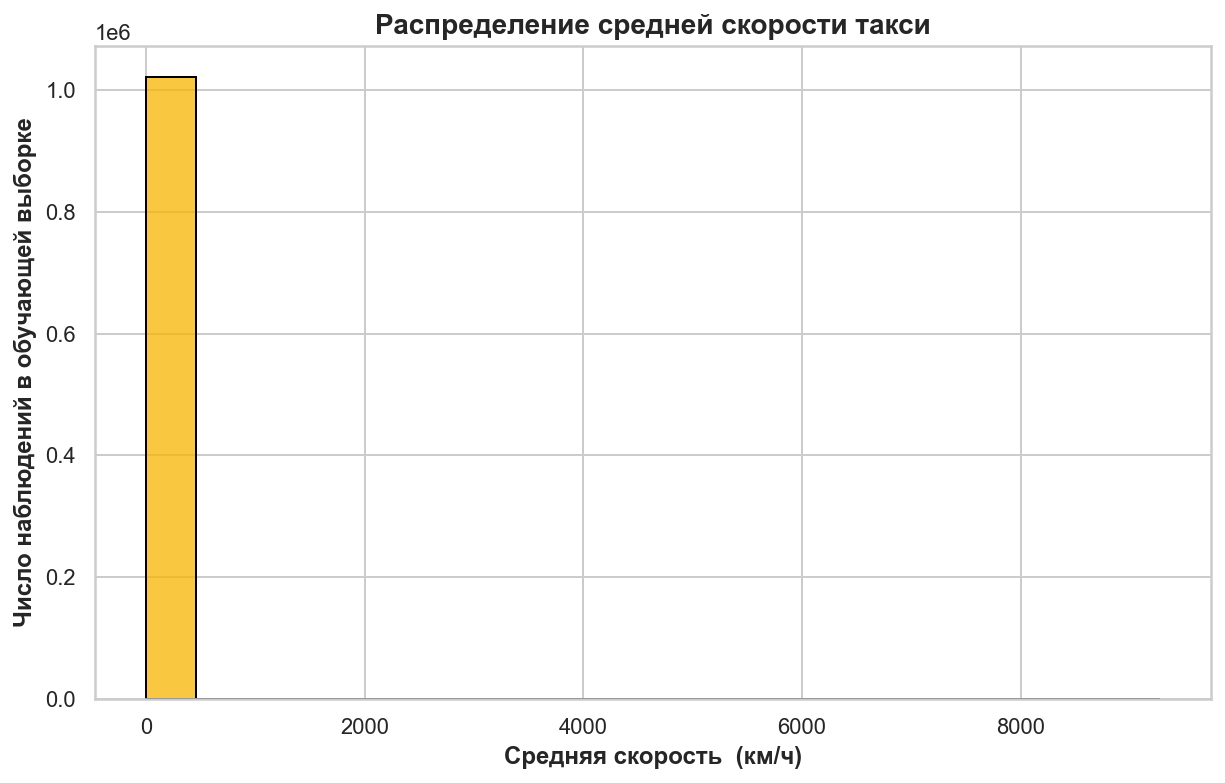

In [50]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Распределение средней скорости такси', fontsize=14, fontweight ='bold')

plt.xlabel('Средняя скорость  (км/ч)', fontsize=12,  fontweight ='bold')
plt.ylabel('Число наблюдений в обучающей выборке', fontsize=12, fontweight ='bold')
sns.histplot(X_train['average_speed'],ax = ax, edgecolor = 'black',  color='#f8b500' , bins = 20);


Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

In [33]:
print('Квантиль уровня 0.995: {}'.format(np.quantile(X_train["average_speed"], q=0.995)))

Квантиль уровня 0.995: 44.87482207190453


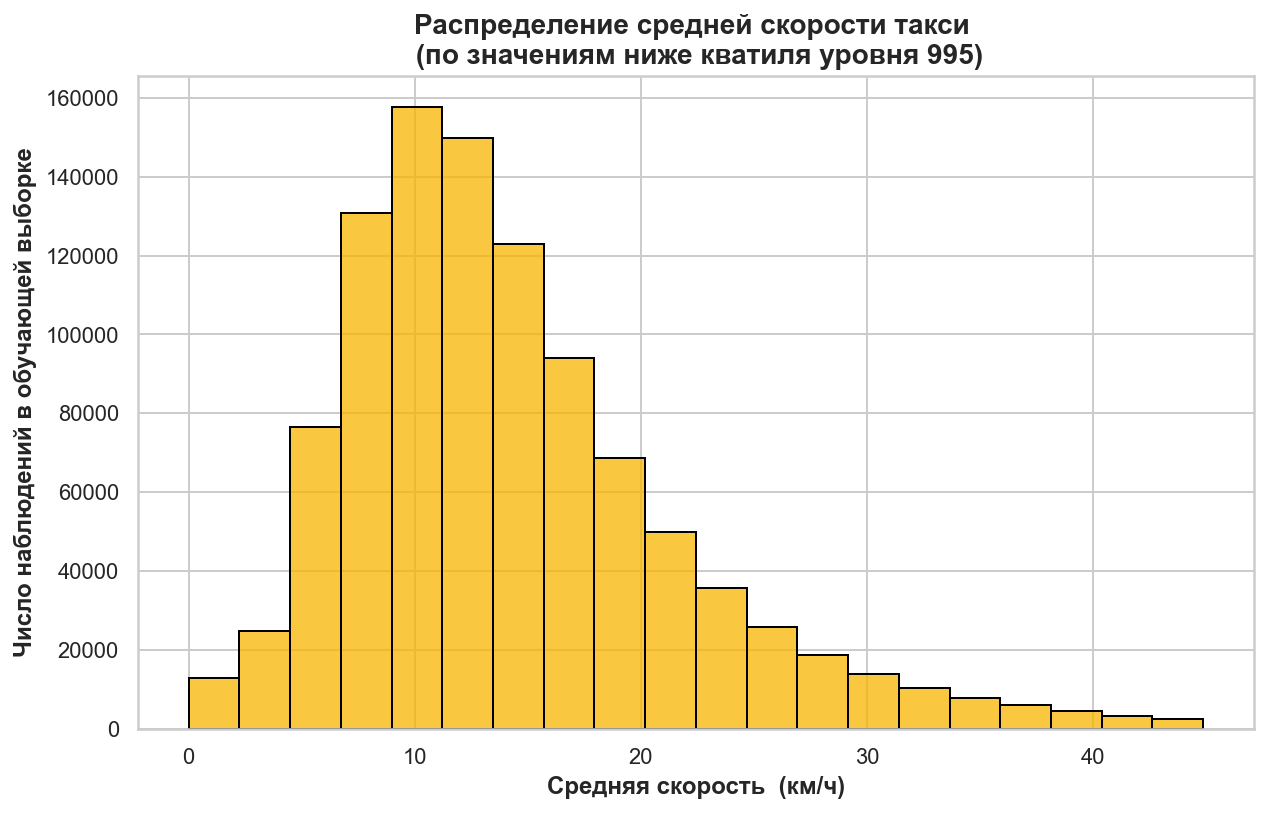

In [156]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Распределение средней скорости такси \n (по значениям ниже кватиля уровня 995)', fontsize=14, fontweight ='bold')

plt.xlabel('Средняя скорость  (км/ч)', fontsize=12,  fontweight ='bold')
plt.ylabel('Число наблюдений в обучающей выборке', fontsize=12, fontweight ='bold')
sns.histplot(X_train[X_train.average_speed < np.quantile(X_train["average_speed"], q=0.995)]['average_speed']
             
             
             ,ax = ax, edgecolor = 'black',  color='#f8b500' , bins = 20);


Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

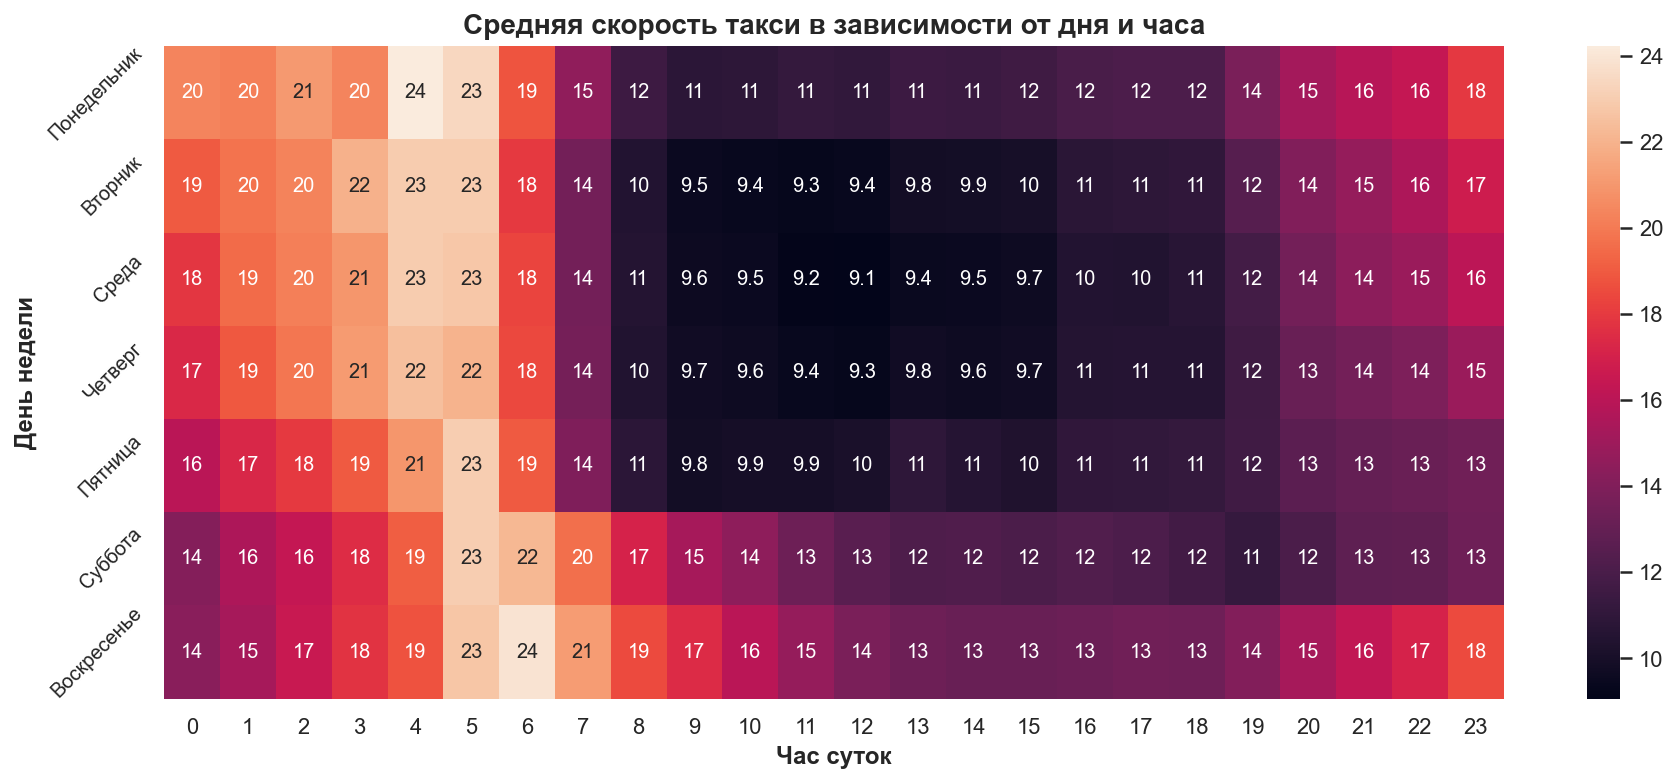

In [52]:
cor_df = X_train.groupby(['day_of_week', 'hour'], as_index = False)['average_speed'].median()

res = cor_df.pivot(index = 'day_of_week', columns ='hour')
res.columns  = res.columns.droplevel(0)
res.reset_index(inplace  = True)
res.drop([ 'day_of_week'], axis=1, inplace=True)

fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(res, ax = ax, annot = True)
ax.set_title('Средняя скорость такси в зависимости от дня и часа', fontsize=14, fontweight ='bold')
ax.set_yticklabels(['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье'], rotation=45, fontsize=10)
ax.set_ylabel('День недели', fontsize=12,  fontweight ='bold')
ax.set_xlabel('Час суток', fontsize=12,  fontweight ='bold');

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

**Ответ:** Скорость рассчитана на основе времени и расстояния, последнее при обучении будет недоступно

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

**Ответ:** Максимальная скорость в будние дни рано утром (1-5 часов утра ), в выходные (5-7 часов утра). Час пик для будней с 8 утра до 17 часов.  Можно проинтерпретировать это как квантили уровня 80 и 20 или 85 и 15.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [34]:
free_way = (
    (df.day_of_week == 0) & (df.hour.isin([0, 1, 2, 3, 4, 5])) |
    (df.day_of_week == 1) & (df.hour.isin([1, 2, 3, 4, 5])) |
    (df.day_of_week == 2) & (df.hour.isin([2, 3, 4, 5])) |
    (df.day_of_week == 3) & (df.hour.isin([2, 3, 4, 5])) |
    (df.day_of_week == 4) & (df.hour.isin([4, 5])) |
    (df.day_of_week == 5) & (df.hour.isin([5, 6, 7])) |
    (df.day_of_week == 6) & (df.hour.isin([5, 6, 7])) 
)
traffic = (
     (df.day_of_week == 1) & (df.hour.isin([8, 9, 10, 11, 12, 13, 14, 15])) |
    (df.day_of_week == 2) & (df.hour.isin([8, 9, 10, 11, 12, 13, 14, 15, 16, 17])) |
    (df.day_of_week == 3) & (df.hour.isin([8, 9, 10, 11, 12, 13, 14, 15, 16])) |
    (df.day_of_week == 4) & (df.hour.isin([9, 10, 11, 12, 15])) 
)

In [35]:
df['free_way'] = 0
df['traffic'] = 0
df.loc[free_way, 'free_way' ] +=1
df.loc[traffic, 'traffic' ] +=1

**Задание 8 (0.25 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака: 
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

Помимо Манхэттена важны аэропорты JFK и  LG. Будем создавать признак по ним. Однако поскольку аэропорт это огромное пространство, где такси может приехать куда угодно (~боль~), поэтому возьму чуть шире. 
Если верить Google maps, нам нужны регионы
 - JFK широты 40.62 - 40.66, долготы -73.85 до -7375.
 - LG широты 40.76 - 40.781, долготы -73.88 до -73.85600

In [36]:
df['take_JFK'] = 0
df['drop_JFK'] = 0
df['take_LG'] = 0
df['drop_LG'] = 0

In [37]:
jfk = (
    ((df.pickup_latitude > 40.62680) & ( df.pickup_latitude < 40.66690)) & 
    ((df.pickup_longitude > -73.82160) & ( df.pickup_longitude < -73.75410) )
)
    
lg = (
    ((df.pickup_latitude > 40.76630) & ( df.pickup_latitude < 40.78160)) & 
    ((df.pickup_longitude > -73.88800) & ( df.pickup_longitude < -73.85600) )
    
)

In [38]:
df.loc[jfk, 'take_JFK'] +=1
df.loc[jfk, 'drop_JFK'] +=1
df.loc[lg, 'take_LG'] +=1
df.loc[lg, 'drop_LG'] +=1

In [39]:
df.loc[df['take_LG'] == 1].shape

(36965, 24)

In [40]:
df.loc[df['drop_LG'] == 1].shape

(36965, 24)

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

Text(0.5, 0, 'Такси отвезло до аэропорта LG')

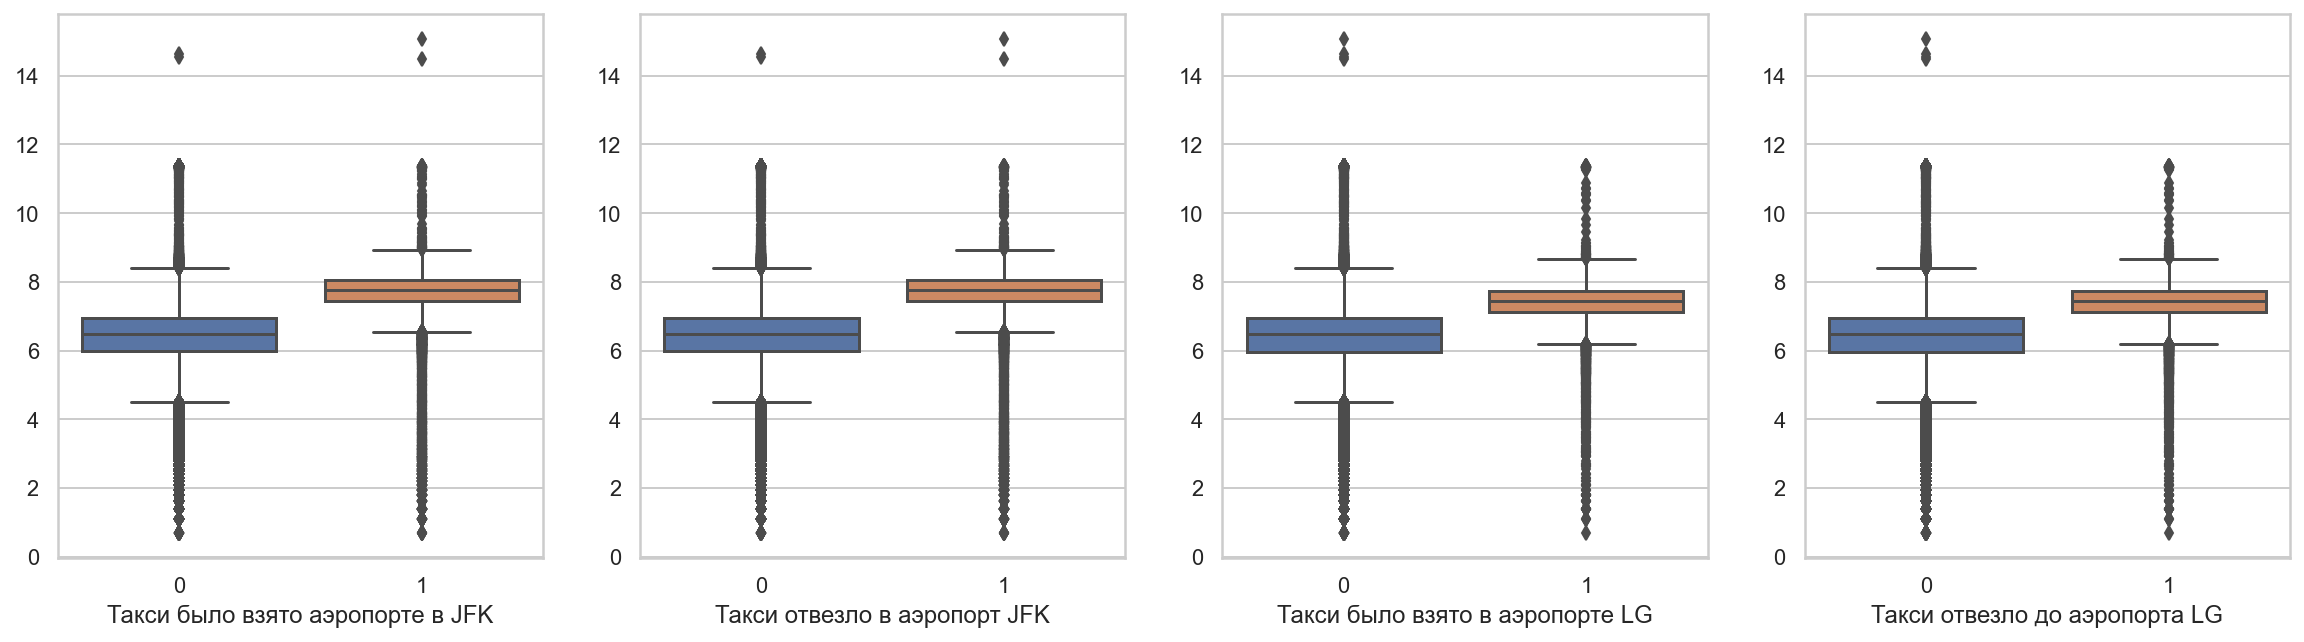

In [60]:
#идея https://stackoverflow.com/questions/38082602/plotting-multiple-different-plots-in-one-figure-using-seaborn

fig, axs = plt.subplots(ncols=4, figsize=(20,5))


sns.boxplot(data = df, x ='take_JFK', y = 'log_trip_duration', ax=axs[0])
axs[0].set_ylabel('')
axs[0].set_xlabel('Такси было взято аэропорте в JFK')


sns.boxplot(data = df, x ='drop_JFK', y = 'log_trip_duration', ax= axs[1])
axs[1].set_ylabel('')
axs[1].set_xlabel('Такси отвезло в аэропорт JFK')

sns.boxplot(data = df, x ='take_LG', y = 'log_trip_duration', ax=  axs[2])
axs[2].set_ylabel('')
axs[2].set_xlabel('Такси было взято в аэропорте LG')


sns.boxplot(data = df, x ='drop_LG', y = 'log_trip_duration', ax=  axs[3])
axs[3].set_ylabel('')
axs[3].set_xlabel('Такси отвезло до аэропорта LG')

Можно заметить много выбросов, для всех графиков. Хоть для JFK ситуация чуть лучше, (возможно т к до него ехать дольше, чем до LG).


**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [41]:
def show_lines_and_circles_on_map(points, line_color='red', weight=5, opacity=1.0, 
        need_points=False, data=None, latitude_column=None, longitude_column=None, 
        point_color='blue', radius=100):

    lats = np.mean([x[0] for x in points])
    lons = np.mean([x[1] for x in points])
    location = (lats, lons)
    m = folium.Map(location=location)

    folium.PolyLine(points, 
        color=line_color,
        weight=weight, 
        opacity=opacity
        ).add_to(m)

    if need_points:
        for _, row in data.iterrows():
            folium.Circle(
                radius=radius,
                location=(row[latitude_column], row[longitude_column]),
                color=point_color,
                fill_color=point_color,
                fill=True
            ).add_to(m)

    return m

In [42]:
def draw_extra_line_on_map(m, points, line_color='red', weight=5, opacity=1.0):
    folium.PolyLine(points, 
        color=line_color,
        weight=weight, 
        opacity=opacity
        ).add_to(m)

    return m

In [43]:
def check_whole_area(df, lat, lon, new_feature):
 
    df[new_feature] = 0

    df.loc[((df[lat] > 40.69982) & (df[lat] < 40.80265)) & \
        ((df[lon] > -74.02096) & (df[lon] < -73.93779)), new_feature] += 1
    
    df_shape = df.loc[df[new_feature] == 1].shape
    print(f'Число интересующих поездок: {df_shape[0]}')

    return df

In [44]:
def make_grid_5x3(list_t):
  
    up_lons = np.linspace(list_t[0][1], list_t[1][1], 4)
    up_lats = np.ones(len(up_lons)) * list_t[0][0]
    up_cord = (up_lats, up_lons)
    up_cord = [(up_cord[0][i], up_cord[1][i]) for i in range(len(up_cord[0]))]

    down_lons = up_lons
    down_lats = np.ones(len(down_lons)) * list_t[2][0]
    down_cord = (down_lats, down_lons)
    down_cord = [(down_cord[0][i], down_cord[1][i]) for i in range(len(down_cord[0]))]

    left_lats = np.linspace(list_t[0][0], list_t[2][0], 6)
    left_lons = np.ones(len(left_lats)) * list_t[0][1]
    left_cord = (left_lats, left_lons)
    left_cord = [(left_cord[0][i], left_cord[1][i]) for i in range(len(left_cord[0]))]

    right_lats = left_lats
    right_lons = np.ones(len(right_lats)) * list_t[1][1]
    right_cord = (right_lats, right_lons)
    right_cord = [(right_cord[0][i], right_cord[1][i]) for i in range(len(right_cord[0]))]

    # задаем координаты в виде "линий"
    line_0 = left_cord
    line_1 = [(left_cord[i][0], down_cord[1][1]) for i in range(6)]
    line_2 = [(left_cord[i][0], down_cord[2][1]) for i in range(6)]
    line_3 = right_cord

    return line_0, line_1, line_2, line_3

In [47]:
from sklearn.base import BaseEstimator, TransformerMixin

 #Манхеттен https://www.latlong.net/place/manhattan-new-york-city-ny-usa-31886.html
# TransformerMixin implements fit_transform for you,
# applying your fit and transform consistently
    
class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # по умолчанию используются следующие координаты р-на Манхэттен: 
        self.up_l = (40.80265, -74.02096)
        self.up_r = (40.80265, -73.93779)
        self.down_l = (40.69982, -74.02096)
        self.down_r = (40.69982, -73.93779)
    
    def show_map(self, df=None, with_points=False, point_feature=None, box_number=1, pickup_or_dropoff='pickup'):
        if with_points:                                                          # если нужно отрисовать точки - координаты поездок
            subset = df.loc[df[point_feature] == box_number]
            print(f'Размер выборки для визуализации: {subset.shape[0]} \
                \nНа карте: 1000 или меньше')

            if pickup_or_dropoff == 'pickup':                                    # выбираем, хотим ли мы отрисовать место назначения
                latitude_column = 'pickup_latitude'                              # или место отправления
                longitude_column = 'pickup_longitude'
            else:
                latitude_column = 'dropoff_latitude'
                longitude_column = 'dropoff_longitude'

            m = show_lines_and_circles_on_map(self.area, weight=8, opacity=1.0, 
                need_points=True, data=subset.sample(1000), latitude_column=latitude_column, 
                longitude_column=longitude_column, point_color="blue")
            m = draw_extra_line_on_map(m, [self.line_1[0], self.line_1[-1]])
            m = draw_extra_line_on_map(m, [self.line_2[0], self.line_2[-1]])

            for i in range(1, 5):
                m = draw_extra_line_on_map(m, [self.line_0[i], self.line_3[i]])
            return m

        m = show_lines_and_circles_on_map(self.area, weight=8, opacity=1.0)
        m = draw_extra_line_on_map(m, [self.line_1[0], self.line_1[-1]])
        m = draw_extra_line_on_map(m, [self.line_2[0], self.line_2[-1]])

        for i in range(1, 5):
            m = draw_extra_line_on_map(m, [self.line_0[i], self.line_3[i]])
        return m

    
    def fit(self, X=None, y=None):
        # создаем сетку, которая будет использоваться для создания признаков и визаулизации
        area = [self.up_l, self.up_r, self.down_r, self.down_l, self.up_l]
        self.line_0, self.line_1, self.line_2, self.line_3 = make_grid_5x3(area)
        self.area = area
        
        return self

    def transform(self, X, y=None):
        df = X.copy()

        # проверим, какие поездки начинаются или заканчиваются в Манхэттене
        df = check_whole_area(df, 'pickup_latitude', 'pickup_longitude', new_feature='is_manh_pickup')
        df = check_whole_area(df, 'dropoff_latitude', 'dropoff_longitude', new_feature='is_manh_dropoff')
        df['box_manh_pickup'] = -1
        df['box_manh_dropoff'] = -1

        # заполним новые признаки - поездка началась или закончилась 
        # в той или иной ячейке новой сетки
        # обработаем ячейки с 1 по 5:
        for i in range(5):
            df.loc[((df['pickup_latitude'] > self.line_0[i+1][0]) & (df['pickup_latitude'] < self.line_0[i][0])) & \
                ((df['pickup_longitude'] > self.line_0[0][1]) & (df['pickup_longitude'] < self.line_1[0][1])), 'box_manh_pickup'] = i+1

            df.loc[((df['dropoff_latitude'] > self.line_0[i+1][0]) & (df['dropoff_latitude'] < self.line_0[i][0])) & \
                ((df['dropoff_longitude'] > self.line_0[0][1]) & (df['dropoff_longitude'] < self.line_1[0][1])), 'box_manh_dropoff'] = i+1

        # обработаем ячейки с 6 по 10:
        for i in range(5):
            df.loc[((df['pickup_latitude'] > self.line_1[i+1][0]) & (df['pickup_latitude'] < self.line_1[i][0])) & \
                ((df['pickup_longitude'] > self.line_1[0][1]) & (df['pickup_longitude'] < self.line_2[0][1])), 'box_manh_pickup'] = i+6

            df.loc[((df['dropoff_latitude'] > self.line_1[i+1][0]) & (df['dropoff_latitude'] < self.line_1[i][0])) & \
                ((df['dropoff_longitude'] > self.line_1[0][1]) & (df['dropoff_longitude'] < self.line_2[0][1])), 'box_manh_dropoff'] = i+6

        # обработаем ячейки с 11 по 15:
        for i in range(5):
            df.loc[((df['pickup_latitude'] > self.line_2[i+1][0]) & (df['pickup_latitude'] < self.line_2[i][0])) & \
                ((df['pickup_longitude'] > self.line_2[0][1]) & (df['pickup_longitude'] < self.line_3[0][1])), 'box_manh_pickup'] = i+11

            df.loc[((df['dropoff_latitude'] > self.line_2[i+1][0]) & (df['dropoff_latitude'] < self.line_2[i][0])) & \
                ((df['dropoff_longitude'] > self.line_2[0][1]) & (df['dropoff_longitude'] < self.line_3[0][1])), 'box_manh_dropoff'] = i+11
        
        return df

Источник функций - https://github.com/VladRub1/ML_projects/blob/main/Linear%20Regression/New%20York%20City%20Taxi%20Trip%20Duration/homework-practice-02-linregr-Rubanov.ipynb

In [48]:
X_train, X_test = train_test_split(df, train_size=0.7, test_size=0.3, random_state=42)

y_train = X_train['log_trip_duration']
y_test = X_test['log_trip_duration']

X_train = X_train.drop('log_trip_duration', axis=1)
X_test = X_test.drop('log_trip_duration', axis=1)

In [49]:
GridTrans = MapGridTransformer()
GridTrans.fit(X_train)
X_train = GridTrans.transform(X_train)
X_test = GridTrans.transform(X_test)

Число интересующих поездок: 934150
Число интересующих поездок: 888291
Число интересующих поездок: 400088
Число интересующих поездок: 380670


**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [50]:
categorial_train = X_train[['day_of_week', 'month', 'hour', 
       'anomalous_date', 'free_way', 'traffic', 'take_JFK', 'drop_JFK',
       'take_LG', 'drop_LG', 'is_manh_pickup', 'is_manh_dropoff',
       'box_manh_pickup', 'box_manh_dropoff']]
numeric_train = X_train[['log_haversine', 'day_of_year']]

categorial_test = X_test[['day_of_week', 'month', 'hour', 
       'anomalous_date', 'free_way', 'traffic', 'take_JFK', 'drop_JFK',
       'take_LG', 'drop_LG', 'is_manh_pickup', 'is_manh_dropoff',
       'box_manh_pickup', 'box_manh_dropoff']]
numeric_test = X_test[['log_haversine', 'day_of_year']]


In [51]:
encoding =  OneHotEncoder(sparse=False)
scaler = StandardScaler()

categorial_train_encoded = encoding.fit_transform(categorial_train)
categorial_test_encoded = encoding.transform(categorial_test)

scaler = StandardScaler()

numeric_train_scaled = scaler.fit_transform(numeric_train)
numeric_test_scaled = scaler.transform(numeric_test)


In [52]:
X_train_transformed = np.concatenate(([categorial_train_encoded, numeric_train_scaled]), axis=1)
X_test_transformed = np.concatenate((categorial_test_encoded, numeric_test_scaled), axis=1)

In [53]:
model = Ridge(random_state=42)

model.fit(X_train_transformed, y_train)
pred_test = model.predict(X_test_transformed)
pred_train = model.predict(X_train_transformed)

rmse_test = mean_squared_error(pred_test, y_test, squared=False)
rmse_train = mean_squared_error(pred_train, y_train, squared=False)

print(f'RMSLE на тесте: {round(rmse_test, 5)}, \nRMSLE на трейне: {round(rmse_train, 5)}')

RMSLE на тесте: 0.47806, 
RMSLE на трейне: 0.47849


Почти в раза лучше, чем в прошлый раз!!!

## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

**Ответ**
 - ```vendor_id``` уникальный номер провайдера - обычно любые столбцы id сразу выкидываются, так как не несут никакой инофрмации, но возможно указание специализации по длительности поездок или назвачению
 - ```passenger_count``` - большая компания людей скорее поедет на далекое расстояние, а один или несколько на небольшое
 - ```store_and_fwd_flag``` - наличие сбоя - возможно нахождение загородом или в сложные погодные условия
 


Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [54]:
feat = ['vendor_id', 'passenger_count' ,'store_and_fwd_flag']

for i in feat:
    print("Признак {} имеет {} уникальных значений. Сами значения {}".format(i,
                                                                             len(df[i].unique()), set(df[i].unique() )
                                                                            )
    )

Признак vendor_id имеет 2 уникальных значений. Сами значения {1, 2}
Признак passenger_count имеет 10 уникальных значений. Сами значения {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Признак store_and_fwd_flag имеет 2 уникальных значений. Сами значения {'Y', 'N'}


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

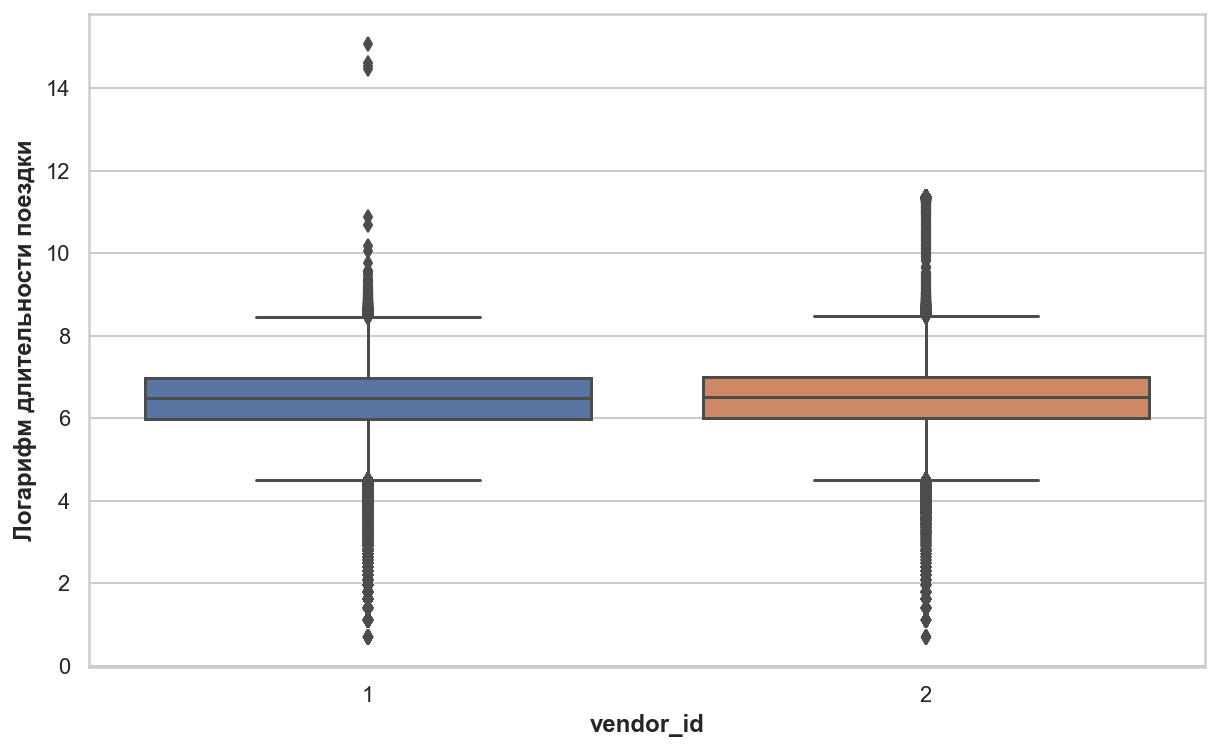

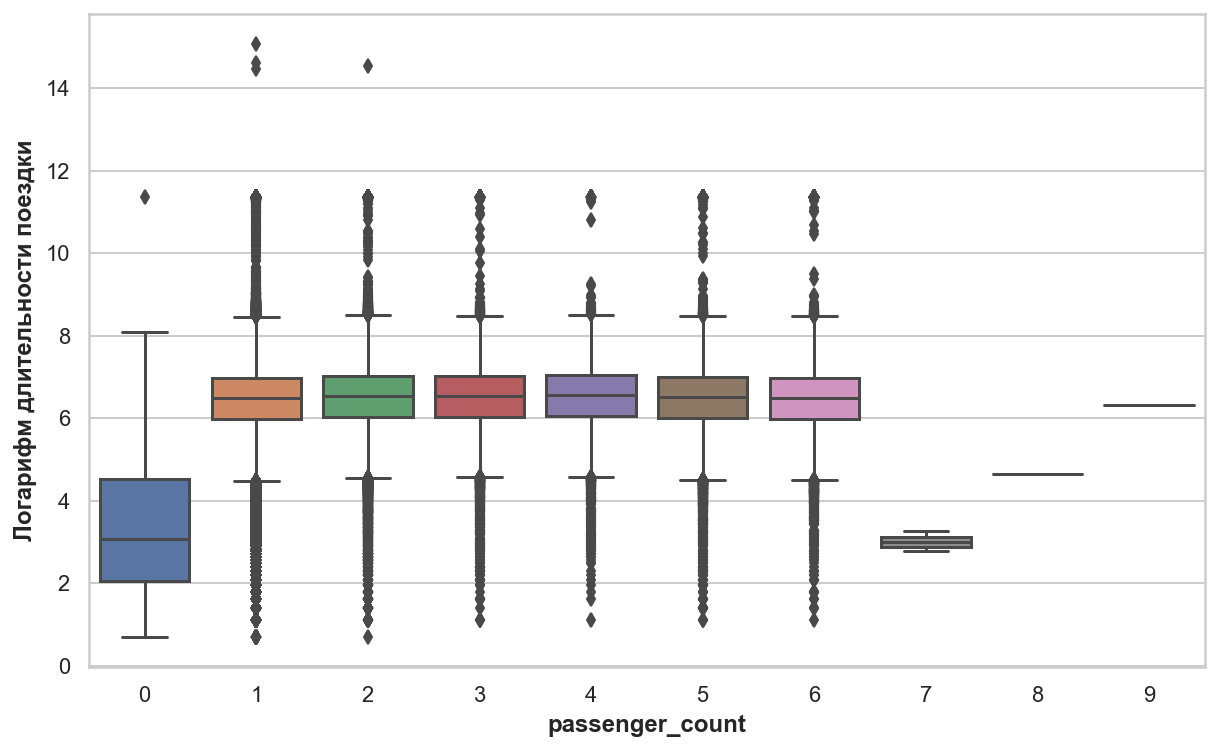

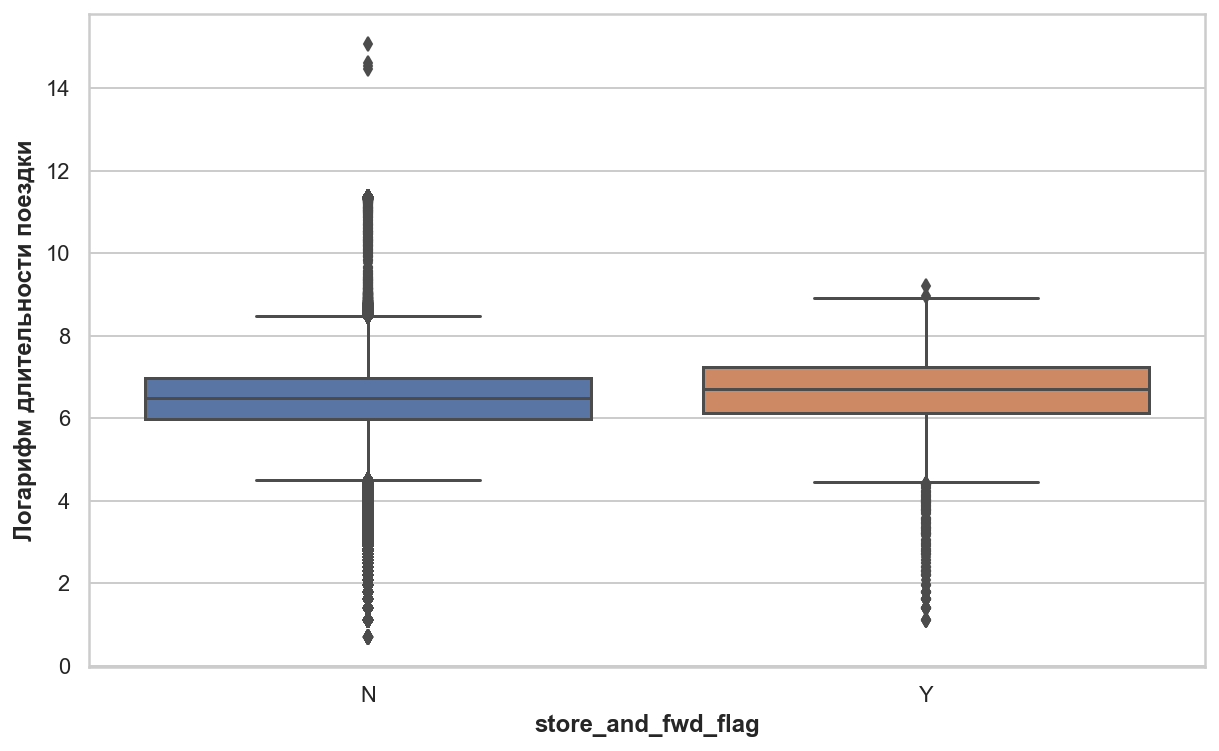

In [73]:
for i in feat:
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(data = df, x=i, y='log_trip_duration', ax =ax);
    plt.ylabel('Логарифм длительности поездки', fontsize=12,  fontweight ='bold')
    plt.xlabel(i, fontsize=12, fontweight ='bold')
    plt.show()
    

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [55]:
df['vendor_id'] = np.where(df['vendor_id'] ==1, 0, 1)
df['store_and_fwd_flag'] = np.where(df['store_and_fwd_flag'] =='Y', 0, 1)

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?
**Ответ** 
 - Номер провайдера бесполезен, значения логарима времени поездки не различаются
 - число пассажиров - в признаке есть 0 пассажиров (sic!). Для количества пассажиров от 1 до 6 таргет почти не разлтчается. Далее идет сильный разброс, но таких значений мало.
 - store_and_fwd_flag - хоть сами ящики находятся примерно в одном положении, есть много выбросов, то есть хоть медианы примерно равны, определенные различия есть

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [56]:
categorical = ['day_of_week', 'month', 'hour', 
       'anomalous_date', 'free_way', 'traffic', 'take_JFK', 'drop_JFK',
       'take_LG', 'drop_LG', 'is_manh_pickup', 'is_manh_dropoff','vendor_id', 'passenger_count', 'store_and_fwd_flag',
       'box_manh_pickup', 'box_manh_dropoff']
numeric = ['log_haversine', 'day_of_year']

In [57]:
transform_column = ColumnTransformer([
    ('encoding', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])


In [58]:
pipeline = Pipeline(steps=[
    ('encoding_and_scaling', transform_column),
    ('regression', Ridge(random_state=42))
])

model = pipeline.fit(X_train, y_train)
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)

rmse_test = mean_squared_error(pred_test, y_test, squared=False)
rmse_train = mean_squared_error(pred_train, y_train, squared=False)

print(f'RMSLE на тесте: {round(rmse_test, 5)}, \nRMSLE на трейне: {round(rmse_train, 5)}')

RMSLE на тесте: 0.47775, 
RMSLE на трейне: 0.47819


По сравнению с прошлым разом стало чуть чуть лучше, оставляем.

Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

Воспользуемся базовыми правилами статистик  для определения выбросов

In [59]:
X_train['log_trip_duration'] = np.log1p(X_train['trip_duration'])

In [60]:
q1 = np.quantile(X_train['log_trip_duration'], q=0.25)
q3 = np.quantile(X_train['log_trip_duration'], q=0.75)
delta = q3 - q1
up_target = q3 + delta*3
down_target = q1 - delta*3

Тоже самое сделаем для haversine

In [61]:
q1 = np.quantile(X_train['log_haversine'], q=0.25)
q3 = np.quantile(X_train['log_haversine'], q=0.75)
delta = q3 - q1
up_haversine = q3 + delta*3
down_haversine = q1 - delta*3

In [62]:
condition1 = (
    (X_train.log_trip_duration >down_target) & (X_train.log_trip_duration < up_target) 
 
)
condition2 = (
    
     (X_train.log_haversine > down_haversine) & (X_train.log_haversine < up_haversine)  
)

In [63]:
X_train1 = X_train[condition1]
X_train2 = X_train[condition2]

Text(0.5, 1.0, 'Распределение таргета без выбросов')

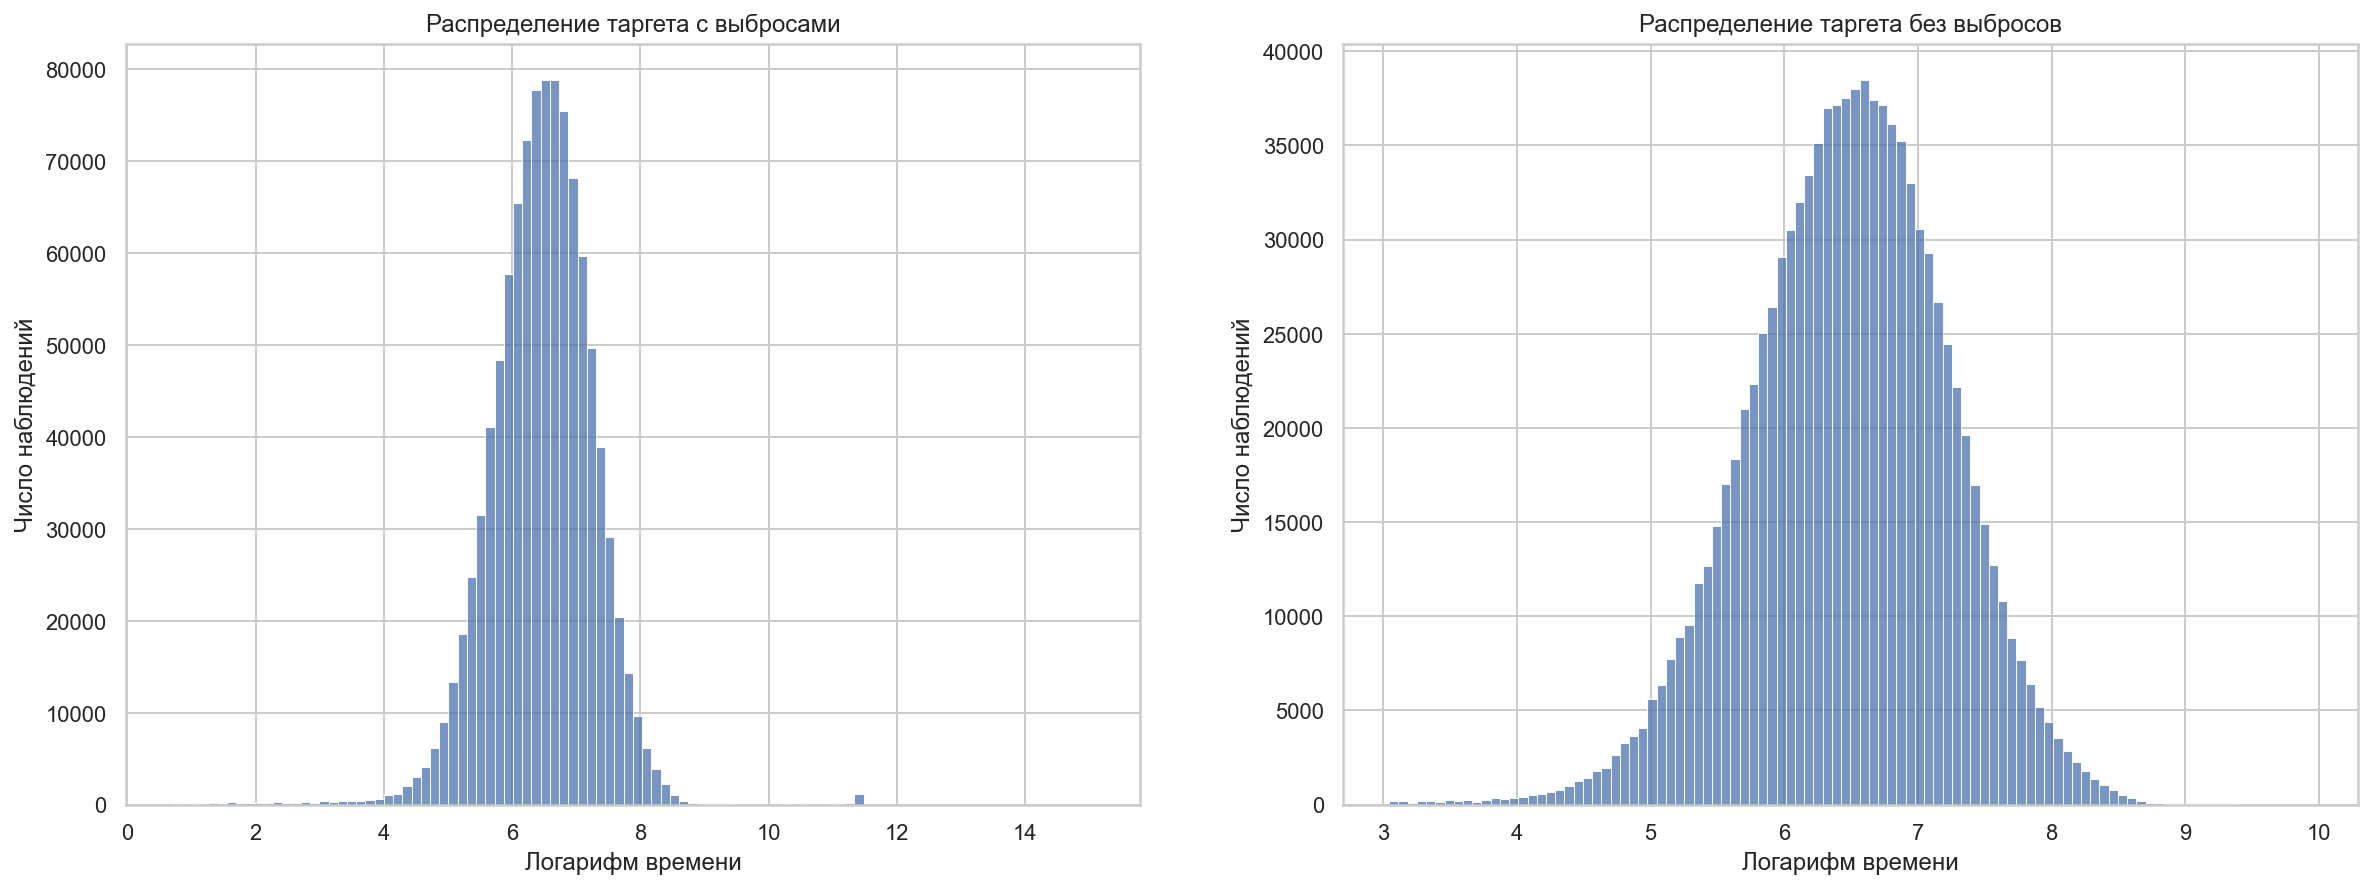

In [83]:
fig, axs = plt.subplots(ncols=2, figsize=(20,7))

sns.histplot(X_train['log_trip_duration'],
             bins=100,
             ax=axs[0]
            )
axs[0].set_ylabel('Число наблюдений')
axs[0].set_xlabel('Логарифм времени')
axs[0].set_title('Распределение таргета с выбросами')


sns.histplot(X_train1['log_trip_duration'],
             bins=100,
             ax=axs[1]
            )
axs[1].set_ylabel('Число наблюдений')
axs[1].set_xlabel('Логарифм времени')
axs[1].set_title('Распределение таргета без выбросов')

Text(0.5, 1.0, 'Распределение скорости без выбросов')

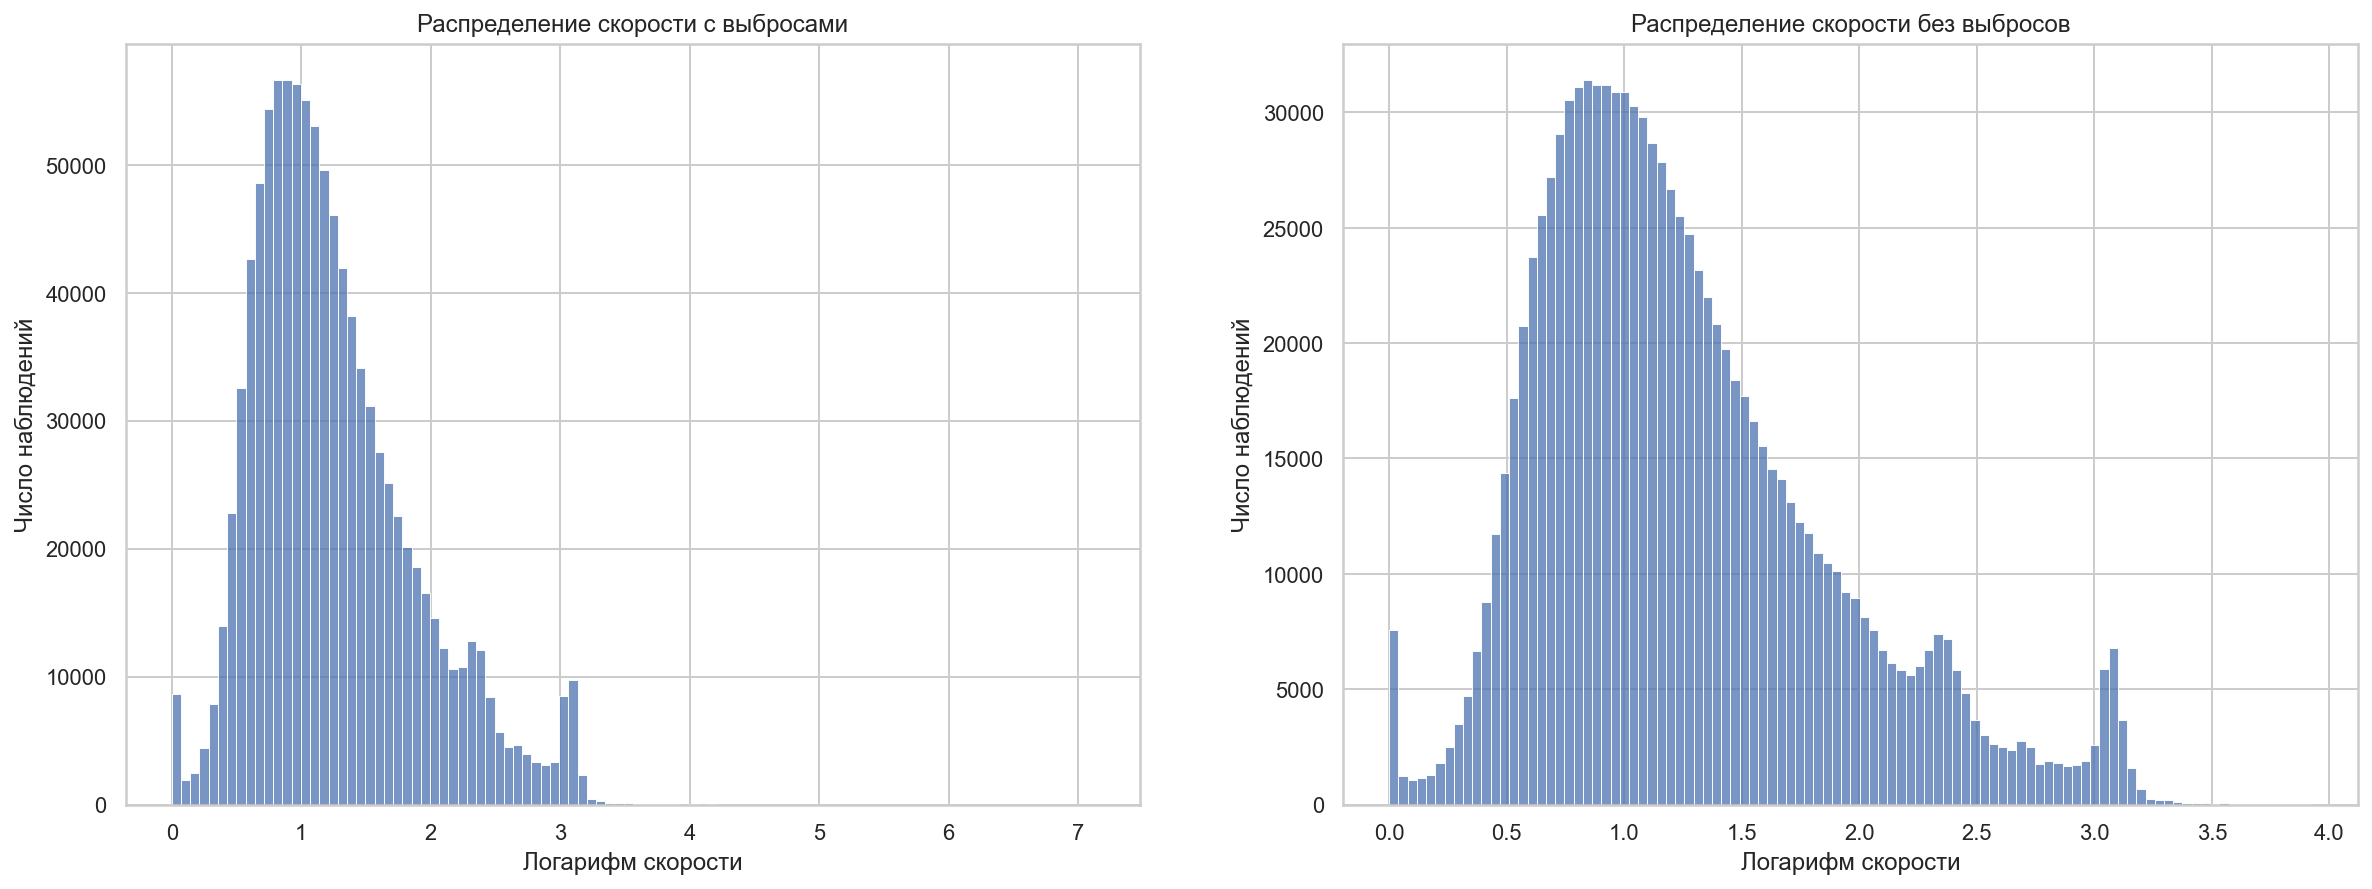

In [200]:
fig, axs = plt.subplots(ncols=2, figsize=(20,7))

sns.histplot(X_train['log_haversine'],
             bins=100,
             ax=axs[0]
            )
axs[0].set_ylabel('Число наблюдений')
axs[0].set_xlabel('Логарифм скорости')
axs[0].set_title('Распределение скорости с выбросами')


sns.histplot(X_train2['log_haversine'],
             bins=100,
             ax=axs[1]
            )
axs[1].set_ylabel('Число наблюдений')
axs[1].set_xlabel('Логарифм скорости')
axs[1].set_title('Распределение скорости без выбросов')

In [98]:
X_cleaned = X_train[condition1 & condition2]
X_cleaned.shape[0] / X_train.shape[0]

0.9960991136575095

Если удалим выбросы так, то потерям менее 1 % !

In [64]:
X_train_cleaned = X_train[condition1 & condition2]

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие). 

Есть сильное искушение объединить числа пассажиров с 1 по 7. Но на боксплоте много выбросов, хоть средние совпали. Имеет смысл скорее объединить странное значения и число пассажиров 8 и 9, так как они малы по численности. 
Также в прямоугольниках Манхеттэна 1, 2, 14, 15 очень мало поездок объединим и их.


In [137]:
X_train_new = X_train_cleaned.copy()
X_test_new = X_test.copy()

In [138]:
X_train_new.loc[X_train_new.box_manh_pickup.isin(box_manh_pickup_unite) ,   'box_manh_pickup'] =  999

In [139]:
X_train_new.loc[X_train_new.passenger_count.isin(passengers) ,   'passenger_count'] =  999

In [140]:
X_train_new['store_and_fwd_flag'] = np.where(X_train_new.store_and_fwd_flag=='Y', 1, 0)
X_test_new['store_and_fwd_flag'] = np.where(X_test_new.store_and_fwd_flag=='Y', 1, 0)
X_train_new['vendor_id'] = np.where(X_train_new.vendor_id==1, 1, 0)
X_test_new['vendor_id'] = np.where(X_test_new.vendor_id==1, 1, 0)

In [141]:
set(X_train_new.columns) - set(X_train_cleaned.columns )

set()

In [144]:
set(X_test.columns) - set(X_test_new.columns)

set()

Было

In [171]:
#y_train = X_train['log_trip_duration']

model = pipeline.fit(X_train.drop('log_trip_duration', axis=1), y_train)
pred_test = model.predict(X_test)
pred_train = model.predict(X_train.drop('log_trip_duration', axis=1))

rmse_test = mean_squared_error(pred_test, y_test, squared=False)
rmse_train = mean_squared_error(pred_train, y_train, squared=False)

print(f'RMSLE на тесте: {round(rmse_test, 5)}, \nRMSLE на трейне: {round(rmse_train, 5)}')

RMSLE на тесте: 0.47775, 
RMSLE на трейне: 0.47819


Очищенные от выбросов

In [74]:
y_train_cleaned = X_train_cleaned['log_trip_duration']

model = pipeline.fit(X_train_cleaned.drop('log_trip_duration', axis=1), y_train_cleaned)
pred_test = model.predict(X_test)
pred_train = model.predict(X_train_cleaned.drop('log_trip_duration', axis=1))

In [75]:
rmse_test = mean_squared_error(pred_test, y_test, squared=False)
rmse_train = mean_squared_error(pred_train, y_train_cleaned, squared=False)

print(f'RMSLE на тесте: {round(rmse_test, 5)}, \nRMSLE на трейне: {round(rmse_train, 5)}')

RMSLE на тесте: 0.47839, 
RMSLE на трейне: 0.41979


Меньше категорий

In [ ]:
X_train_new.loc[X_train_new.box_manh_pickup.isin(box_manh_pickup_unite) ,   'box_manh_pickup'] =  99
X_train_new.loc[X_train_new.passenger_ count.isin(passengers) ,   'passenger_count'] =  10

X_train_new['store_and_fwd_flag'] = np.where(X_train_new.store_and_fwd_flag=='Y', 1, 0)
X_test_new['store_and_fwd_flag'] = np.where(X_test_new.store_and_fwd_flag=='Y', 1, 0)
X_train_new['vendor_id'] = np.where(X_train_new.vendor_id==1, 1, 0)
X_test_new['vendor_id'] = np.where(X_test_new.vendor_id==1, 1, 0)

In [90]:
box_manh_pickup_unite = [1, 2, 14, 15]
passengers = [0, 8, 9]

X_train_new = X_train_cleaned.copy()
X_test_new = X_test.copy()

X_train_new.loc[X_train_new.box_manh_pickup.isin(box_manh_pickup_unite) ,   'box_manh_pickup'] =  99
X_train_new.loc[X_train_new.passenger_count.isin(passengers) ,   'passenger_count'] =  -2


X_test_new.loc[X_test_new.box_manh_pickup.isin(box_manh_pickup_unite) ,   'box_manh_pickup'] =  99
X_test_new.loc[X_test_new.passenger_count.isin(passengers) ,   'passenger_count'] =  -2


X_train_new['store_and_fwd_flag'] = np.where(X_train_new.store_and_fwd_flag=='Y', 1, 0)
X_test_new['store_and_fwd_flag'] = np.where(X_test_new.store_and_fwd_flag=='Y', 1, 0)

X_train_new['vendor_id'] = np.where(X_train_new.vendor_id==1, 1, 0)
X_test_new['vendor_id'] = np.where(X_test_new.vendor_id==1, 1, 0)

In [91]:
y_train_cleaned = X_train_new['log_trip_duration']

model = pipeline.fit(X_train_new.drop('log_trip_duration', axis=1), y_train_cleaned)
pred_test = model.predict(X_test_new)
pred_train = model.predict(X_train_new.drop('log_trip_duration', axis=1))



rmse_test = mean_squared_error(pred_test, y_test, squared=False)
rmse_train = mean_squared_error(pred_train, y_train_cleaned, squared=False)

print(f'RMSLE на тесте: {round(rmse_test, 5)}, \nRMSLE на трейне: {round(rmse_train, 5)}')

RMSLE на тесте: 0.47842, 
RMSLE на трейне: 0.41983


Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

До

In [94]:
X_train_new[categorical].shape[1]

17

После

In [95]:
encoder= OneHotEncoder(sparse=False)
encoder.fit_transform(X_train_new[categorical]).shape[1]

96

In [99]:


pipeline_lasso = Pipeline(steps=[
    ('ohe_and_scaling', transform_column),
    ('regression', Lasso(random_state=42))
])

y_train_cleaned = X_train_new['log_trip_duration']

model = pipeline.fit(X_train_new.drop('log_trip_duration', axis=1), y_train_cleaned)
pred_test = model.predict(X_test_new)
pred_train = model.predict(X_train_new.drop('log_trip_duration', axis=1))



rmse_test = mean_squared_error(pred_test, y_test, squared=False)
rmse_train = mean_squared_error(pred_train, y_train_cleaned, squared=False)

print(f'RMSLE на тесте: {round(rmse_test, 5)}, \nRMSLE на трейне: {round(rmse_train, 5)}')

RMSLE на тесте: 0.47842, 
RMSLE на трейне: 0.41983


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [104]:
pipeline_lasso = Pipeline(steps=[
    ('ohe_and_scaling', transform_column),
    ('regression', Lasso(random_state=42))
])


y_train_cleaned = X_train_new['log_trip_duration']

model = pipeline.fit(X_train_new.drop('log_trip_duration', axis=1), y_train_cleaned)
pred_test = model.predict(X_test_new)
pred_train = model.predict(X_train_new.drop('log_trip_duration', axis=1))



rmse_test = mean_squared_error(pred_test, y_test, squared=False)
rmse_train = mean_squared_error(pred_train, y_train_cleaned, squared=False)

print(f'RMSLE на тесте: {round(rmse_test, 5)}, \nRMSLE на трейне: {round(rmse_train, 5)}')

RMSLE на тесте: 0.47842, 
RMSLE на трейне: 0.41983


Разбейте _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [105]:
y_train = X_train_new['log_trip_duration']

In [106]:

X_train_new2, X_values, y_train_new2, y_values = train_test_split(X_train_new, y_train, train_size=0.8, test_size=0.2, random_state=42)



Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

*К счастью для проверяющего это конец, дальше не не хватило сил...*

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [76]:
#!pip install h3
import h3

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.